In [1]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Reshape, Conv2D, ZeroPadding2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adadelta, RMSprop
from tensorflow.keras import regularizers
import pickle
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.model_selection import train_test_split
import collections
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, Input, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Cropping2D
from tensorflow.keras.layers import LeakyReLU
from sklearn.metrics import precision_recall_curve, roc_curve, auc, average_precision_score
from sklearn.model_selection import StratifiedKFold
from keras.callbacks import TensorBoard

import os
import matplotlib.pyplot as plt

os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2" #model will be trained on GPU 0
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
def getDataForCAE():
    A = open('TCGA_new_pre_second.pckl', 'rb')
    [dropped_genes_final, dropped_gene_name, dropped_Ens_id, samp_id_new, diag_name_new,
    project_ids_new] = pickle.load(A)
    A.close()

    f = open('TCGA_new_pre_first.pckl', 'rb')
    [_, _, _, _, remain_cancer_ids_ind, remain_normal_ids_ind] = pickle.load(f)
    f.close()

    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(project_ids_new)
    # binary encode
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    onehot_encoded_cancer_samples = onehot_encoded[remain_cancer_ids_ind]

    X_cancer_samples = dropped_genes_final.iloc[:,remain_cancer_ids_ind].T.values
    X_cancer_samples_mat = np.concatenate((X_cancer_samples, np.zeros((len(X_cancer_samples), 305))), axis=1)
    X_cancer_samples_mat = np.reshape(X_cancer_samples_mat, (-1, 86, 86))
    
    X = X_cancer_samples_mat
    X = np.reshape(X, (len(X), 86, 86, 1))    
    
    Y = onehot_encoded_cancer_samples
    #Y = np.argmax(Y, axis=1)
    
    return X, Y

In [3]:
features = ['GPRIN1', 'EFNB1', 'FABP4', 'MGP', 'AC020916-1', 'CDC7', 'CHADL', 'VPS9D1-AS1', 'RPL10P6', 'OASL', 'PRSS16', 'CXCL10', 'GATA3', 'GABRP', 'SFRP2', 'SLN', 'LRIG1', 'MTCO1P53', 'SAMHD1', 'CLTRN', 'BNC1', 'ANO7', 'AL603825-1', 'PSPHP1', 'LAPTM5', 'AC005082-1', 'TBC1D4', 'LGALS1', 'SEMA4C', 'AC026403-1', 'CWH43', 'CDS1', 'HAGLROS', 'TIMD4', 'SEMA3E', 'GP2', 'IVL', 'TRIM17', 'EN1', 'OGT', 'MTND2P28', 'SLC15A2', 'KREMEN2', 'SULT4A1', 'EMP2', 'TFF3', 'OSMR', 'GBP4', 'RAVER1', 'PCOLCE2', 'SLC16A4', 'RGS20', 'LINC01605', 'TFAP2A', 'CAPNS2', 'CYBRD1', 'PAPSS2', 'RASL10B', 'PLEKHA2', 'ADCY3', 'FOXP4', 'KLHL14', 'LBX2-AS1', 'AC099850-3', 'SPAG5', 'GFRA2', 'MIR205HG', 'TRIM16', 'GPR34', 'DNAJC15', 'SLC37A1', 'FOXD3-AS1', 'MUC15', 'CLCA2', 'SHB', 'BCL6B', 'SCUBE3', 'FTH1P20', 'CALD1', 'COL4A4', 'ERVMER34-1', 'TNNC1', 'AP1M2', 'SNAI2', 'POR', 'EFNA1', 'IGLV1-41', 'ADAM28', 'NPNT', 'ARL6IP5', 'NOTCH4', 'DHCR24', 'PTPN14', 'ADAMTSL2', 'CDCA4', 'PGM1', 'RGS1', 'ESR1', 'AC005336-1', 'HAAO', 'LMX1B', 'RAPGEF4', 'SLC2A2', 'ACHE', 'F5', 'RAB26', 'GJB1', 'CHRM1', 'LINC02562', 'GDPD3', 'NDRG1', 'RAD54L', 'EFNA2', 'ALDOC', 'SYT12', 'LINC00634', 'RPS18', 'NKD2', 'SLC20A2', 'GOLGA2P10', 'CABYR', 'TBC1D16', 'SULF1', 'PKIG', 'TMEM229B', 'HSPB2', 'CHST15', 'CD27', 'NKD1', 'MEIS3', 'NPAS2', 'SPRR1B', 'C1QTNF3', 'DSP', 'AC005077-4', 'MAPRE3', 'CMKLR1', 'TMEM178B', 'COL3A1', 'EAF2', 'TRGC2', 'CREB5', 'SLC16A2', 'ARHGEF15', 'PIR', 'CD209', 'PALMD', 'ARHGAP24', 'TSPAN5', 'FXYD2', 'PLCB2', 'OAS1', 'HCN2', 'NIPAL1', 'CLIC3', 'CXCL9', 'TMEM14A', 'MTSS1', 'SPRR1A', 'KRT13', 'GPAT3', 'THPO', 'SMIM24', 'FES', 'MMP7', 'CLIC4', 'CHST6', 'CDC6', 'ICAM1', 'APLP1', 'FTLP3', 'FCMR', 'NRCAM', 'NKX3-1', 'AP000769-1', 'PLOD1', 'C5orf38', 'WIPF3', 'PTN', 'C3orf18', 'RRAS', 'TFR2', 'AMIGO1', 'FXYD6', 'DSCC1', 'MEGF6', 'PIK3IP1', 'KRT23', 'CFL2', 'BUB1', 'LINC02541', 'AXIN2', 'PLEKHG1', 'IGSF9', 'GCNT2', 'GPR183', 'NAAA', 'FABP1', 'KIAA1147', 'COL14A1', 'PHGDH', 'PEG3', 'HOXA13', 'PON3', 'DANCR', 'TMEM51', 'SCGB1D2', 'SLC16A6', 'ITGA8', 'LLGL2', 'CTSW', 'OCIAD2', 'FDCSP', 'DAAM2', 'AL136454-1', 'C1orf210', 'GPD2', 'IL17RD', 'ESRRA', 'STRA6', 'COMP', 'MANSC1', 'BGN', 'CADM4', 'MT1F', 'AL139396-1', 'RRM2', 'RCOR2', 'CRISP3', 'NIPSNAP2', 'CLIP2', 'BIRC5', 'TJP3', 'OCLN', 'HLA-DPA1', 'DKK1', 'FAHD2CP', 'POU3F3', 'AMBP', 'KANK1', 'PCP4', 'TSPAN12', 'CXCL1', 'SMOC1', 'KCNS3', 'SMPD1', 'LTB', 'HAS2', 'SLC27A6', 'SH3PXD2A', 'SIGLEC8', 'RBP1', 'EXO1', 'SRM', 'GPRASP1', 'ZNF300', 'LGR4', 'PLPP5', 'GMDS', 'FAM84B', 'FOXO6', 'B3GALT5', 'PDE3A', 'CHAF1A', 'EVA1C', 'P2RY6', 'BST1', 'KDELC2', 'CD207', 'GFRA3', 'KLF13', 'EMP1', 'CTSC', 'ABCC5', 'LSR', 'ERBB4', 'AP001972-5', 'MFAP5', 'ROR2', 'DCTPP1', 'ASPN', 'AP1S3', 'RPL22L1', 'SLC22A18', 'GALK1', 'ACBD4', 'KRT1', 'S100A1', 'GGT5', 'SPATA18', 'TNFAIP8', 'MIRLET7D', 'IL24', 'SULT2B1', 'ABHD11', 'FAM50B', 'TFF1', 'AIFM3', 'MIR4653', 'TYMS', 'CYP4F29P', 'IP6K3', 'LINC01770', 'CHST1', 'FAM234B', 'STARD10', 'ZNF43', 'CRCT1', 'HRASLS2', 'HENMT1', 'MFSD10', 'SLC16A9', 'IGHV2-70', 'DDIT3', 'CXCL5', 'NXPH4', 'ARHGEF2', 'EHHADH', 'C9orf116', 'NKAIN1', 'JUP', 'RF00019-062', 'SAMSN1', '1-Mar', 'GNG3', 'U62317-2', 'SGPP2', 'ALDH3A1', 'ITGA3', 'BICDL2', 'SPATC1L', 'RTL8C', 'CX3CR1', 'C5orf30', 'POMC', 'PDE6B', 'SHE', 'UNC93B1', 'FABP3', 'EPB41L3', 'SELENON', 'PCGF2', 'MIR3176', 'CDC45', 'ATP6V1B2', 'ZBTB42', 'MEGF9', 'TCIM', 'TMEM79', 'ALDH1L1', 'PTPRN', 'TSC22D3', 'SHF', 'GJC1', 'HPSE', 'CREB3L2', 'EVA1A', 'AC107983-1', 'ALDH4A1', 'MIR31HG', 'CYB5A', 'IGHV3-30', 'RGS14', 'MFSD12', 'SULT1C4', 'CYB5D2', 'MYH14', 'MSI2', 'GJC3', 'AL158206-1', 'BRSK2', 'DIRAS3', 'LINC01116', 'ATP6V0D2', 'WFS1', 'MUC4', 'ANTXR2', 'FOS', 'TRIP6', 'GRB10', 'HIST1H2BO', 'TCEAL1', 'IGKV1-8', 'CAD', 'PPIF', 'WNT2', 'SH3YL1', 'KIF16B', 'NPR1', 'TSPAN9', 'DDO', 'COL9A3', 'MAP3K8', 'GALNT3', 'NSUN7', 'SPOCK2', 'SLC26A7', 'COL18A1', 'CENPU', 'CDC42EP5', 'TMEM37', 'ARC', 'REEP4', 'EPOR', 'GRAMD2A', 'PPP1R3B', 'CMTM7', 'DDR2', 'IGFBP5', 'LZTS3', 'LRRC10B', 'CSGALNACT1', 'AC093001-1', 'SLC16A11', 'CXCR4', 'COL23A1', 'PAM', 'AC138305-3', 'HCG11', 'FRZB', 'BTN3A1', 'PHPT1', 'KLK6', 'TESC', 'HJURP', 'P2RY1', 'NRSN2', 'LST1', 'ABHD11-AS1', 'THSD4', 'HLA-DPB1', 'GPCPD1', 'HRH2', 'KCNJ15', 'HIST1H2BH', 'CAVIN2', 'IGKV2D-24', 'GRAMD2B', 'UQCRH', 'MAP7', 'BPIFB2', 'LRRC32', 'CXCL2', 'SAMD11', 'CYP4X1', 'CDCA5', 'LGALS9', 'N4BP3', 'INPP5F', 'RAC3', 'ADRA1B', 'KRT81', 'FAM83H', 'TRIM29', 'TUBA1A', 'SH3BP1', 'EDN3', 'ACSM2A', 'RPL4P4', 'CAPN13', 'DAB2', 'NECTIN3', 'CARD11', 'BIN2', 'NPDC1', 'SNHG6', 'CPT1A', 'KRT8', 'SLC4A7', 'KIF13B', 'LRRC15', 'AC090515-4', 'CERS1', 'PPARGC1A', 'IRX2', 'XG', 'KCNJ2', 'MFSD2A', 'CA12', 'SEC14L2', 'IL2RG', 'FBXL16', 'PBK', 'SOX7', 'UBA7', 'RHOV', 'PSMB8-AS1', 'SREBF2', 'ENHO', 'FIBIN', 'SLC2A4', 'RPL7P1', 'PARVB', 'TRIM55', 'ZNF608', 'ALDH1L2', 'SLC43A2', 'MCEMP1', 'PSAT1', 'AL445189-2', 'CDC42BPG', 'SLC25A4', 'SMIM14', 'ADAMTS14', 'GPR37', 'VNN1', 'NLGN1', 'RUBCNL', 'EPHX4', 'NXN', 'MTFR2', 'C19orf71', 'RF00019-010', 'GIMAP8', 'HAPLN1', 'CDH4', 'HAMP', 'SUCLG2', 'MTCO3P12', 'SFTA3', 'SPR', 'GLRB', 'CAP2', 'SECISBP2L', 'P3H3', 'SNORD62B', 'DTX3', 'BMPR1B', 'AP002387-1', 'ECEL1', 'CPAMD8', 'PRUNE2', 'TFDP1', 'C2', 'PLK2', 'SCNN1B', 'ALB', 'PLCL2', 'ACTA2', 'SNX10', 'CRYBG1', 'MUCL1', 'IRF1', 'CYSLTR2', 'FZD4', 'CLDN2', 'FPR3', 'ZNF711', 'CACNB3', 'FOXA3', 'SLC9A3-AS1', 'CNP', 'ANKH', 'HSPA2', 'RUSC2', 'ANXA10', 'GNG4', 'DDX60', 'TMEM198', 'OPLAH', 'CALML5', 'A2M', 'HEBP2', 'COL8A2', 'ACTC1', 'LIPG', 'ARHGEF26', 'ZNF367', 'FCGR3A', 'IRX3', 'NADK2', 'FOXS1', 'USP30-AS1', 'MT1G', 'NDUFS8', 'CYP21A1P', 'CPEB2', 'HNRNPCP2', 'MTND4LP30', 'MELK', 'DHRS7', 'ABTB2', 'TACC3', 'WSB1', 'SYTL2', 'KLHDC7A', 'STAT5A', 'SVIP', 'C1S', 'ACSS3', 'C20orf85', 'PLEKHS1', 'IER2', 'PADI2', 'PLCD3', 'SSR4', 'AC015922-3', 'BTN3A2', 'SAA1', 'EBP', 'CD96', 'CCDC88B', 'HSPA7', 'GPC6', 'TANC2', 'ENPP1', 'PGM5', 'SCTR', 'PTPRD', 'TGFB1', 'CD93', 'AUNIP', 'ACTN4', 'PERP', 'FST', 'MNX1-AS1', 'RPS6', 'SKP2', 'AC004540-2', 'MTURN', 'ZNF528-AS1', 'ZNF467', 'LINC01006', 'KCTD3', 'MEOX1', 'EDEM1', 'EIF4EBP1', 'ITLN1', 'TLN2', 'SELENOP', 'HK2', 'AL591845-1', 'MASP2', 'CENPA', 'NAV2', 'MSMB', 'SYT11', 'STOM', 'DOCK11', 'AC090498-1', 'DLG5', 'CYTIP', 'HS6ST2', 'AC060780-3', 'LOXL1', 'PIP4K2A', 'IFI16', 'RPL7P9', 'NMRAL2P', 'CDKN2C', 'FNBP1', 'LRRC31', 'EFR3B', 'VAMP5', 'HSD17B8', 'SRMS', 'GJA5', 'CLSTN1', 'ITGB1', 'UCN2', 'AP001453-2', 'MCRIP2', 'LRG1', 'CCDC106', 'RNU4-1', 'SLC10A3', 'IGHV1-67', 'NFASC', 'SAMD9', 'EFEMP2', 'LIPA', 'FRMD5', 'IBSP', 'GOLM1', 'GLTPD2', 'CD79B', 'AC093297-2', 'C3orf52', 'PRNP', 'MFNG', 'P2RX7', 'POSTN', 'PCAT6', 'MAP3K1', 'COL1A1', 'NET1', 'PFKM', 'FKBP4', 'DNAJB4', 'CALB2', 'FBXO6', 'SNORD100', 'GALNT18', 'C19orf33', 'PTX3', 'MUC2', 'SNHG9', 'SPARC', 'ACSM5', 'MS4A1', 'RTKN', 'WASF1', 'HERC2P2', 'AC023043-1', 'PHYHIPL', 'KCNJ3', 'FBXO2', 'GZMA', 'RPS7P1', 'MICAL1', 'RHOBTB2', 'TMOD2', 'DHCR7', 'PAQR7', 'AHCYL2', 'SDCBP', 'ASCL2', 'YPEL3', 'HIBADH', 'IGKV6D-21', 'CTNND1', 'NDN', 'ENO2', 'MT1E', 'S1PR5', 'PTGES', 'CD274', 'LDOC1', 'IVNS1ABP', 'SMIM10L2A', 'MBP', 'RTL6', 'PDPN', 'REEP6', 'IGHJ2', 'STEAP3', 'SERTAD4', 'DACT1', 'GZMH', 'CLU', 'CLMP', 'GRIA2', 'SPINT1-AS1', 'BCAR3', 'TGFBR2', 'UNC13D', 'ADGRL1', 'ADCY6', 'NFKBIA', 'ARID5B', 'FFAR2', 'SCGB1A1', 'HERC6', 'PRKCI', 'WFDC21P', 'FXYD5', 'NMNAT3', 'CLEC11A', 'FER1L4', 'TBX2-AS1', 'SORBS3', 'CXADR', 'RPL8', 'NAPSB', 'CRYL1', 'PTPRN2', 'KLF5', 'CNTNAP1', 'BORCS7', 'PRF1', 'FAM89A', 'TSPO', 'AC104692-1', 'STAB1', 'BRSK1', 'SDK1', 'ENPP4', 'AIF1', 'OLFML2B', 'PKIB', 'ARRB1', 'LRRC8A', 'HDAC1', 'CFB', 'HSPB6', 'TSPAN11', 'SCG2', 'CHN1', 'PNPLA2', 'RAC2', 'AC009549-1', 'PIP', 'MAGEA3', 'LRP5', 'TUBG2', 'APOBEC3A', 'ZDHHC2', 'CLIC1', 'ITPKA', 'SORT1', 'ENTPD5', 'IER5', 'PLCL1', 'AC048341-2', 'CTGF', 'LRRC75A', 'NREP', 'CCL13', 'MEX3D', 'WWC2', 'JPT2', 'CDH1', 'TYRO3', 'XIST', 'DEPP1', 'P2RY8', 'CPEB4', 'S100B', 'FCN1', 'ERO1A', 'WAS', 'CORO1C', 'FAM241B', 'AC141557-1', 'PKDCC', 'ARHGAP4', 'CLMN', 'HS3ST2', 'STX1A', 'KIF26B', 'SH2B3', 'MYD88', 'C1orf116', 'AC133134-1', 'TPRN', 'GYPC', 'MIR186', 'CHRDL1', 'PKIA', 'THBS2', 'TREM2', 'LINC01806', 'UTRN', 'LDHB', 'EDAR', 'TMSB4X', 'CD70', 'SNHG19', 'AC104825-1', 'DCHS1', 'NFE2L3', 'CD36', 'MPZL3', 'CRAT', 'CD34', 'BEND5', 'ADSSL1', 'SIX2', 'NRN1', 'CCR2', 'ODC1', 'TRIL', 'ADGRB2', 'NECTIN1', 'AFAP1-AS1', 'TNFAIP8L3', 'PTK6', 'F7', 'AC093535-2', 'ABHD8', 'FLT4', 'ZBTB47', 'C2orf88', 'C4orf19', 'CYC1', 'CHST10', 'PAQR4', 'RNASET2', 'SERPINE1', 'MYLIP', 'FAM107B', 'PEA15', 'PPL', 'ITM2B', 'PLXDC1', 'FAM13A', 'ACADS', 'RPL13', 'EIF3L', 'CST3', 'LY6D', 'GPC2', 'AL118505-1', 'GNG12', 'HLA-DRA', 'OVOL1', 'CROT', 'FUT3', 'EXT1', 'ADORA1', 'MIA', 'CCL11', 'VASN', 'VAT1', 'S1PR2', 'LPAR6', 'TPM1', 'RPL35', 'IL11RA', 'WNT10A', 'EPHB4', 'HIST1H1E', 'TNIK', 'RALGPS2', 'INSYN1', 'SELENOM', 'MORN4', 'NXNL2', 'ITGAV', 'SNHG18', 'GSTM2', 'MTCO2P22', 'TNFRSF10D', 'LPAR1', 'FBXO44', 'NFIA', 'IL13RA2', 'ANXA8L1', 'LBH', 'ADRB2', 'ITIH3', 'SHCBP1', 'AL355338-1', 'FAAH2', 'SMTN', 'KLK5', 'RCAN1', 'SOWAHA', 'CDYL2', 'BTK', 'H2AFX', 'CD86', 'ACOX2', 'C8G', 'BATF2', 'AGER', 'MIR503HG', 'EPHB2', 'ANXA11', 'NUDT4', 'SHANK3', 'SCAMP5', 'FAM19A5', 'AL049555-1', 'RPS19', 'ECT2', 'AGAP2-AS1', 'CHST2', 'MLPH', 'NRARP', 'TGM2', 'HPCAL1', 'ARHGEF10L', 'TP53I11', 'GBP6', 'DOK1', 'ITGA4', 'TMEM200A', 'RRBP1', 'AC113935-1', 'CBX6', 'IQGAP3', 'KDM7A-DT', 'ITGBL1', 'CCL4L2', 'RGS19', 'CLCN3', 'CYB5R2', 'DPEP1', 'ACACB', 'AL049838-1', 'IL6R', 'CSPG5', 'EPS8L3', 'HOXC4', 'PLP1', 'CCNG1', 'PBXIP1', 'PLCG2', 'SMAGP', 'AC078864-1', 'FBXL7', 'RNU6-850P', 'CYP4B1', 'SLC22A23', 'ANOS1', 'IGHV3-19', 'HLA-DRB6', 'FBXL6', 'DDT', 'ELOVL2', 'AC004687-1', 'PVR', 'PRRX1', 'CSRP1', 'TRIP10', 'MFSD3', 'MIR4768', 'ID2', 'ARSI', 'RGL3', 'TBC1D2', 'DDIT4L', 'ACTN2', 'FAM155B', 'LYPD6', 'POU5F1', 'BX322562-1', 'OR51E1', 'C1QTNF1', 'MMD', 'FAM107A', 'CYB5R1', 'AQP5', 'ADPRHL1', 'ZNF883', 'RFLNA', 'COL11A1', 'KLF11', 'DNAJC6', 'MMP9', 'CABLES1', 'C2CD4A', 'GLYCTK', 'FBLN1', 'SLC14A1', 'AC025857-2', 'ZDHHC12', 'CDC42EP3', 
            'PI3', 'MARVELD2', 'TRABD2B', 'RASGEF1A', 'AL355353-1', 'ILF3-DT', 'TTC39A', 'GDF10', 'RIC3', 'ANKRD35', 'JAM2', 'FGA', 'EGFL6', 'PECR', 'SPARCL1', 'UAP1L1', 'STIL', 'HIST2H2AC', 'C3orf14', 'WDR86-AS1', 'HOXB13', 'PRSS35', 'ZCCHC24', 'DNPH1', 'AL161787-1', 'THBS1', 'TMEM74B', 'LMNA', 'PFKP', 'BCL2', 'DNAJA4', 'MAL', 'ZMAT1', 'PITPNM1', 'COL4A6', 'FBN2', 'SLC3A1', 'MESP1', 'PSCA', 'PLA2G4F', 'SFTPA2', 'PAIP2B', 'ARL4A', 'MRGPRF', 'TP63', 'GLT8D2', 'CLDND1', 'AFAP1L2', 'HIST1H3H', 'CCDC146', 'VCAN', 'AC009065-5', 'GATA4', 'CYP2S1', 'TMEM102', 'SLC44A3', 'CHML', 'NCAPG2', 'PGC', 'LIX1', 'NT5DC2', 'RNF182', 'TTPA', 'TPSD1', 'IFT57', 'ORM2', 'ZNF512B', 'SCEL', 'FBXO41', 'HOXA4', 'IGHV3OR16-13', 'CDK1', 'BDKRB2', 'CEACAM1', 'GPR153', 'CASC10', 'ENPP2', 'FAM110B', 'KRT7', 'ANXA3', 'RUFY3', 'AP002761-4', 'HTRA3', 'ATP6V1C2', 'SLC37A4', 'TUBB6', 'LRP8', 'ADAM23', 'TIMM8AP1', 'PLS1', 'RPS28P7', 'FCRLA', 'NEFL', 'LENG8', 'KIF22', 'B4GALNT1', 'ITPRIPL2', 'REX1BD', 'PCDH7', 'TMEM38B', 'SLC1A2', 'INHA', 'RNASE1', 'SOX18', 'SUCNR1', 'INAFM2', 'RIPK4', 'SYNM', 'COL6A2', 'CYP4F12', 'AC009065-2', 'HIST1H3B', 'RHBDF2', 'NDUFA3', 'P3H2', 'HPR', 'KRTDAP', 'CXCL11', 'RND3', 'TAGLN3', 'MIR3609', 'PHACTR1', 'AC090559-1', 'KPNA2', 'CLCA4', 'SFXN5', 'C17orf97', 'ARAP3', 'SPRY4', 'CD2AP', 'RAB3D', 'ARHGAP40', 'HYAL1', 'TMEM54', 'PPP1R13L', 'RHBDL1', 'SELP', 'PCBP4', 'ATF3', 'VPREB3', 'LPAR3', 'NOX4', 'SOWAHB', 'P2RY13', 'JUN', 'LINC00672', 'CPLX1', 'SLC39A8', 'SPAG1', 'RCN1P2', 'MYO1D', 'GNG2', 'AL365181-2', 'PPIC', 'ABHD6', 'PLA2R1', 'LINC01671', 'MCM4', 'PLS3', 'MST1P2', 'FTL', 'NAGS', 'SLC5A1', 'AL391121-1', 'DOK7', 'HOXB4', 'TMEM38A', 'ATAD2', 'MIR9-3HG', 'DUSP14', 'AKR1B1', 'AKR7A3', 'LGALS7', 'EEF1A1P11', 'SH3RF2', 'PSD4', 'SPATA13', 'SLC37A2', 'PLAC9', 'MYRIP', 'TAP2', 'NECTIN2', 'C6orf132', 'CNDP2', 'MAGEA6', 'HLF', 'VAMP2', 'PLCXD1', 'ZNF185', 'MAP1A', 'PLVAP', 'TOR4A', 'CILP', 'AC080112-1', 'LDB2', 'ABLIM3', 'TUBB', 'APBB1', 'TPRG1', 'GALNT11', 'MCRIP1', 'GPR155', 'PROM2', 'MACC1', 'FAM83B', 'ZNF83', 'PLXNA3', 'RPL18', 'PPP1R16A', 'CXXC4', 'ALG3', 'DUOX1', 'SAMD12', 'RNF157-AS1', 'ASAP1', 'LAG3', 'MME', 'FBXO17', 'VTCN1', 'MMRN1', 'SHTN1', 'CLEC12A', 'PTGIS', 'CISD3', 'P4HA1', 'MPZL1', 'GNE', 'HOOK1', 'B4GALT5', 'RTP4', 'RERG', 'ECM2', 'PACSIN1', 'LIF', 'CCDC28B', 'LINC01857', 'NPM2', 'KCTD12', 'CDX1', 'AC073861-1', 'GOLT1A', 'SPC24', 'BICC1', 'RASL11B', 'NANS', 'RPL18AP3', 'AC022784-1', 'SPIN4', 'TMIE', 'RFTN1', 'CUBN', 'RAB30', 'TCF7', 'DNAJB9', '10-Sep', 'ZNF385A', 'PCK2', 'TTC3', 'AXL', 'AC012213-4', 'MYEOV', 'PRSS8', 'PRICKLE1', 'PLOD3', 'LINC01436', 'HIST3H2A', 'PHACTR3', 'HCFC1R1', 'AGPAT5', 'AC010422-3', 'IFI6', 'MPP7', 'WASF3', 'IGSF3', 'CTNND2', 'ARHGAP11A', 'SRD5A3', 'FOXP1', 'CPNE5', 'AL590560-1', 'SLC2A10', 'SORD2P', 'ANXA2', 'COL15A1', 'CMTM4', 'ZNF117', 'HOXB7', 'HDGFP1', 'AC110285-2', 'TPSG1', 'RASD1', 'CHEK2', 'CYP2D6', 'CTSO', 'NBEAL2', 'SLURP1', 'CMTM8', 'HIF1A', 'PLPPR2', 'MINOS1P3', 'TMEM154', 'PLA2G4C', 'RPL29P19', 'IGHV3OR16-9', 'SNRPGP2', 'CDH6', 'PHYHD1', 'RNF112', 'RABEP1', 'HIST1H1PS1', 'AC092868-1', 'SLC22A18AS', 'TNFAIP8L2', 'ELN', 'INSIG1', 'SDCBP2', 'CADM1', 'ENO3', 'MTCO1P2', 'ASNS', 'NR2F6', 'CKMT2', 'CHODL', 'NOXA1', 'TMEM145', 'TMSB4XP8', 'VEGFB', 'SH3RF3', 'AC254633-1', 'IFI35', 'MDK', 'ANKRD10-IT1', 'LY6E', 'HRAS', 'FGF2', 'PLLP', 'IGSF8', 'ZEB2', 'LINC00958', 'TSPYL4', 'FAM117A', 'TMEM87B', 'TFF2', 'CD177', 'AC245041-2', 'THCAT158', 'RPL41P1', 'ADGRG1', 'IL7R', 'PDGFC', 'CYTOR', 'C1QA', 'APBB1IP', 'C2orf72', 'SAMD5', 'KLRB1', 'CD200', 'KCNN2', 'MOGAT3', 'ABCC4', 'FAM229B', 'KIF2A', 'IGHV4-31', 'RASSF7', 'AP005233-2', 'MIAT', 'ITGB5', 'ATP2B2', 'IFNGR1', 'ATAD3C', 'LMOD1', 'IGFBP7', 'TMEM47', 'DLX3', 'FAM83F', 'PCED1B', 'GSTA4', 'IGHV4-59', 'LYNX1', 'CERKL', 'PHYH', 'GLCE', 'CCNB2', 'ORAI2', 'ANGPT1', 'BBOX1-AS1', 'FBLN2', 'SLC16A1', 'SLC30A4', 'AC103810-3', 'LINGO1', 'APOA1', 'DOCK9', 'FEN1', 'PFN2', 'RPS20P14', 'CCDC9B', 'TNFSF13B', 'GRTP1', 'MPST', 'MACROD1', 'ALS2CL', 'BTN3A3', 'RF02271', 'CDC42EP4', 'DQX1', 'LAP3', 'B3GNT2', 'AKT3', 'EPOP', 'MMP24', 'ADGRF4', 'PRPS2', 'INPP5D', 'RPS27AP16', 'KCNAB1', 'CHCHD2P2', 'HOXC-AS1', 'CCL21', 'GAPDHP1', 'P2RX1', 'LINC01023', 'HERPUD1', 'TMEM56', 'FMO2', 'CHP2', 'KCNK2', 'ABR', 'VSIG1', 'NR4A2', 'GPR27', 'ROMO1', 'TSTD1', 'FNBP1L', 'TMPRSS4', 'GS1-124K5-4', 'NOG', 'FURIN', 'HIST1H1C', 'MIR222HG', 'NFKBIZ', 'NQO1', 'PTPRF', 'HLA-DQB1', 'ANP32E', 'MT2A', 'SLC50A1', 'STAT1', 'GNL3L', 'FDXR', 'NPPC', 'HRASLS', 'RASSF9', 'ARHGAP31', 'GSTA1', 'ST6GAL1', 'GCAT', 'GRB14', 'SERPINE2', 'VAT1L', 'CLDN9', 'MS4A7', 'TEAD1', 'MBOAT2', 'FAM69B', 'LSP1', 'TNK1', 'LFNG', 'FOXA1', 'LHFPL3', 'LIPC', 'NFKBIE', 'HBA2', 'NDNF', 'SLC16A3', 'RRAGD', 'TMEM238L', 'ERO1B', 'TIPARP', 'WDR91', 'AC008556-1', 'GATM', 'CYP2U1', 'FUT2', 'ZAP70', 'ACSM3', 'KIAA1551', 'TSPAN18', 'TAGLN2', 'LINC02560', 'NMU', 'CYTL1', 'SPOCK1', 'CCL8', 'CHMP4C', 'AC079630-1', 'ARHGEF16', 'SPRED1', 'CHAF1B', 'SEZ6L2', 'AC021218-1', 'ZBED6CL', 'GADD45B', 'VOPP1', 'SFRP4', 'C11orf54', 'CX3CL1', 'ABCB1', 'PAH', 'CKB', 'MARK1', 'IL22RA1', 'SEC14L6', 'IGFL1', 'CENPM', 'HELLS', 'TPX2', 'FRMD3', 'UGT8', 'AC246787-1', 'DMRT2', 'LAD1', 'AP002360-1', 'ZFPM2-AS1', 'CXCL12', 'C1QC', 'CETP', 'ENG', 'PARD6G', 'RPS10', 'FGFBP2', 'APOL2', 'ETHE1', 'KISS1', 'NINJ2', 'AC124312-5', 'APOE', 'MSRB3', 'NNAT', 'MXRA8', 'CCDC69', 'YAP1', 'SYN1', 'PADI3', 'BAG3', 'ADAMTS9', 'TAX1BP3', 'NCAPD2', 'AC015922-2', 'AC245884-12', 'ITGA1', 'AC018638-5', 'THEMIS2', 'AZGP1', 'SESTD1', 'TFPI2', 'VCAM1', 'CDK6', 'WNK4', 'LDLRAD3', 'LRFN1', 'RPS13P2', 'IGHV1-24', 'FLNC', 'TP53I3', 'IGLC6', 'ATP13A2', 'KCNF1', 'CLIP3', 'KDM5D', 'PDZD2', 'PRKAG2-AS1', 'TCEA3', 'COL12A1', 'TMTC1', 'FAM3C', 'CD24', 'NLGN4X', 'TNNI3', 'CENPX', 'TNFRSF10A', 'NBEA', 'PMP2', 'MARVELD1', 'HOXA9', 'MIPEP', 'H3F3A', 'OSGIN1', 'LGALS3', 'SMIM2-AS1', 'UGCG', 'RNU4ATAC', 'SPTSSA', 'ITGB2-AS1', 'TCF7L1', 'SMC4', 'C4A', 'TFCP2L1', 'AC009283-1', 'TRPV6', 'IGKV1OR2-108', 'AL445524-1', 'STARD8', 'AC005392-2', 'CCNL2', 'KNDC1', 'KIF23', 'IRX4', 'CALU', 'GRN', 'HOXA11-AS', 'TRBJ2-1', 'GIPC1', 'STEAP1B', 'NEDD9', 'AC113191-1', 'KCNN3', 'RCN1', 'ENTPD7', 'SPDEF', 'KDELR3', 'PHLDA1', 'RNU6-403P', 'SLC25A5', 'AREG', 'CKM', 'NR3C2', 'MYBPC1', 'CRYM', 'COL4A3', 'TRIM31', 'RHOU', 'RNA5SP111', 'ARHGEF35', 'SERPINB13', 'CXCL16', 'FGG', 'MRPL12', 'MIR4477B', 'MAPK10', 'ALCAM', 'OIP5', 'AL121820-2', 'PLA2G12B', 'RPS15', 'HEPH', 'ADAM33', 'RHOB', 'LMO2', 'EEF1A2', 'COL5A3', 'RSPH1', 'CACNA2D1', 'TMEM256', 'GAMT', 'HOXD10', 'TMEM101', 'TKT', 'HBEGF', 'PLSCR1', 'MS4A6A', 'RAB3B', 'RTN4RL2', 'RNU1-70P', 'RAI14', 'CAMK2N1', 'PROC', 'DNAJB1', 'MS4A4A', 'ERAP1', 'GJB2', 'MAFF', 'FAT2', 'FAM84A', 'TENM2', 'FLRT1', 'APOC3', 'KLF6', 'HGD', 'ADTRP', 'METRN', 'CD5', 'AL627309-7', 'WNT4', 'ABI3BP', 'RIPK3', 'DOCK8', 'NRIP2', 'CMTM6', 'SLC43A3', 'RCN3', 'AC138207-3', 'LMNB1', 'SERPINA11', 'FBP1', 'IGKV5-2', 'RUNX1', 'IGFBP3', 'ARRDC3', 'AHNAK', 'SLC6A13', 'PAX2', 'FAXDC2', 'TYROBP', 'VAV3', 'TUBA1B', 'CAVIN3', 'PLA2G4A', 'ENPEP', 'IGKV1-9', 'AC079250-1', 'IL17RE', 'SPX', 'KCTD15', 'SSPN', 'ALKBH7', 'TMEM52', 'ABCC3', 'ZMYND10', 'CCR5', 'IGKV1-12', 'LMCD1', 'WEE1', 'LEF1', 'ATP6V0C', 'SLC7A8', 'CPNE1', 'UNC119B', 'ASMTL-AS1', 'ERAP2', 'CCL20', 'TNFRSF25', 'SOSTDC1', 'SESN1', 'HSD17B6', 'CST2', 'STK26', 'PPP1R1B', 'ITGB6', 'DCN', 'SYN2', 'CORO2B', 'CP', 'PTMAP4', 'PGM2', 'GPX7', 'TGFA', 'HMGCS1', 'VEPH1', 'CHTF18', 'MCM5', 'FAM166B', 'AL691432-2', 'MAN1A1', 'SULT1A1', 'BANK1', 'CDH3', 'ATP6V0A4', 'BCAT1', 'CKAP2L', 'ETS1', 'TMEM108', 'AL590666-2', 'AC244153-1', 'CAT', 'BAG2', 'AP001324-1', 'PCDH10', 'ANK2', 'NDFIP2', 'NAT1', 'FERMT2', 'CPS1', 'TLE4', 'KIAA1324', 'STX1B', 'SMPD3', 'AC025259-3', 'RERGL', 'SOWAHC', 'ADAM9', 'IL6', 'SLC12A7', 'COL5A1', 'RPLP2', 'HIST1H2BJ', 'IL2RA', 'IQGAP2', 'PLPP4', 'PRKCD', 'HAVCR2', 'PDLIM1', 'ITGAM', 'CDC25A', 'DOCK9-DT', 'HBB', 'PIGR', 'PM20D2', 'NCF2', 'SPTSSB', 'AL450405-1', 'SULT1C2', 'SCAND1', 'PPFIBP1', 'SNORC', 'PTPRC', 'LIMK2', 'FAM20A', 'LMNB2', 'H2AFY2', 'ADD2', 'CD40', 'PLA2G2D', 'RBP4', 'USP9Y', 'ADCY5', 'ATF5', 'COLCA2', 'FMN1', 'NCF4', 'C1orf21', 'GGCT', 'RF00019-1', 'MIR4635', 'EMB', 'PKD2', 'NRM', 'SYBU', 'CDCA3', 'RPL39P3', 'TPBGL', 'PALLD', 'MYO1A', 'VXN', 'PIK3CD-AS2', 'RPLP1', 'LY6G6C', 'SLC16A5', 'ARHGAP18', 'MAGI2', 'C6orf226', 'DMGDH', 'ZYX', 'SLC49A3', 'AC010487-1', 'PRC1', 'TMEM45A', 'MIR6772', 'TMSB4XP1', 'CPPED1', 'C7', 'FAM3B', 'EPHA3', 'AC018665-1', 'GADD45G', 'AC008735-2', 'VDR', 'NSG1', 'STMN1', 'ZBTB18', 'FGD5', 'CHST13', 'PLEKHF1', 'CALCRL', 'CERS4', 'DCDC2', 'PRLR', 'ALPL', 'LYPLA1', 'AC010503-4', 'CXorf36', 'NANOS1', 'CLEC2B', 'CACNA1D', 'SEMA5B', 'AMPH', 'TMEM132A', 'MSR1', 'ATP7B', 'SORBS2', 'TCAP', 'TRIM14', 'PPM1L', 'SMIM25', 'DMBT1', 'RPL3P4', 'KANSL1-AS1', 'OGN', 'PODXL', 'SCARNA6', 'PLA2G1B', 'GIMAP2', 'XYLT1', 'HEBP1', 'BHLHE40', 'AP006284-1', 'ELMO1', 'STMN2', 'PNISR', 'EPS8L1', 'ARRDC2', 'AL671277-1', 'ID1', 'AC020907-1', 'AC239859-6', 'TPM2', 'IGHV3-43', 'ENKD1', 'PQLC3', 'PLXNC1', 'RAB25', 'RNASE2', 'APCDD1', 'GIMAP4', 'PRR16', 'UNC13B', 'CYP26B1', 'LRRN2', 'PHGR1', 'RNASEH2A', 'BCAR1', 'CXCR2P1', 'AC068587-2', 'ANKRD29', 'MKI67', 'BACE2', 'RPL23AP42', 'BCL9L', 'MT1A', 'ENC1', 'LYZ', 'OVGP1', 'SNORD14A', 'GPA33', 'LTBP1', 'DPM3', 'PLA1A', 'FERMT1', 'TUSC8', 'S100A12', 'ATP8B2', 'MVP', 'EDIL3', 'RNF19B', 'MPZL2', 'CTSF', 'SMAD9', 'CCNA2', 'RASSF6', 'SPN', 'CELSR3', 'TMEM61', 'BTBD3', 'EGLN3', 'SERPIND1', 'SLIT2', 'ARHGDIG', 'MBOAT1', 'IGKV1D-13', 'LPXN', 'IL1B', 'LARGE2', 'TOX', 'EVL', 'RNA5SP498', 'PEBP4', 'SNHG8', 'MND1', 'ADAMTS8', 'CAV1', 'AC133065-3', 'AL031727-1', 'BMP6', 'EXTL1', 'RF00100', 'SLC47A1', 'SPIRE2', 'FNDC1', 'SLC35F2', 'CD248', 'AC093162-2', 'FREM2', 'AC005912-1', 'C16orf45', 'LRRC61', 'IKZF3', 'CPA4', 'NOS2', 'SYDE1', 'SFXN3', 'ACAA2', 'MIR4740', 'Z74021-1', 'LAMP3', 'MANEAL', 'SOX2', 'MOGAT2', 'CYP4V2', 'PTGS1', 'SHC1', 'GALNT13', 'SPINK2', 'PPP1R15A', 'DMD', 'ABRACL', 'CALML3', 'PPP2R3A', 'VWA7', 'EFEMP1', 'KLF9', 'CA8', 'SLC38A1', 'PSMG3', 'MAPK8IP1', 'PWAR6', 'UPK3A', 'JAK3', 'IGHV1-12', 
            'AC124067-2', 'MILR1', 'RAB6B', 'MIR590', 'KBTBD11', 'THEM6', 'GALM', 'NAP1L3', 'RUNX3', 'BMP1', 'C6', 'SLC4A3', 'EDN2', 'TP53INP1', 'FYB1', 'CKMT1A', 'COMTD1', 'SLC26A4', 'PDLIM3', 'MIR3671', 'NLGN2', 'KDM5B', 'ICA1', 'NDC80', 'ADGRE5', 'MAGEH1', 'LGALS4', 'PRSS21', 'PNP', 'NOV', 'KIF5A', 'COX6C', 'ZDHHC20', 'DECR2', 'PRDM8', 'SLC11A1', 'PELI1', 'OLR1', 'GBP2', 'HLA-K', 'MSI1', 'ITM2C', 'GABBR1', 'MGAT5', 'CELSR1', 'DEPDC1', 'TUSC3', 'NFAT5', 'AL009174-1', 'F11R', 'RNF128', 'TRO', 'RNF145', 'CENPW', 'HMGB1P10', 'CD19', 'AGAP2', 'WIPI1', 'SLC22A31', 'IGHJ1', 'CFD', 'SLC38A5', 'LEPR', 'ERG', 'PRKX', 'SLC26A9', 'ZNF521', 'DTX2', 'CRMP1', 'KIAA1324L', 'CANT1', 'CSRP2', 'DSG3', 'PID1', 'MT1X', 'CRLF1', 'ABCA3', 'UNC5B', 'AFAP1L1', 'MAP9', 'NDC1', 'ALYREF', 'PECAM1', 'RAB3A', 'LAMB2', 'QSOX1', 'RPS3', 'TMEM8B', 'PRKAR1B', 'AKR1B15', 'CAST', 'LAMC3', 'LINC01133', 'NIPAL3', 'TMEM238', 'SLC46A3', 'SDC4', 'C5orf49', 'MCM2', 'BLVRA', 'HELZ2', 'RPL26P19', 'MYO10', 'SLC19A3', 'SNHG12', 'BDH2', 'IGSF11', 'PARP14', 'CNTN1', 'SEMA3C', 'SYT7', 'HLA-DOB', 'APLP2', 'CACHD1', 'IL4I1', 'FTCD', 'RF00019-2', 'PDE1A', 'ASAP2', 'ADH1C', 'INPP4B', 'EPHA2', 'SEMA3B', 'ALOX15', 'CH25H', 'FGF7P3', 'SFTPC', 'PPP1R18', 'SEMA5A', 'SLC52A3', 'LINC01094', 'IQANK1', 'HLA-C', 'SIGLEC10', 'KMT2E-AS1', 'EMILIN1', 'PIPOX', 'PIM2', 'ETV7', 'ZNF296', 'NGF', 'SFTPA1', 'CD37', 'SRPK1', 'CCND2', 'ABCC6', 'CAPN8', 'FCGR2A', 'CREB3L3', 'KRT18', 'DOK4', 'IRX6', 'MGMT', 'WDR86', 'STC1', 'RASL12', 'AC092535-4', 'CARD16', 'EZR', 'ALPK3', 'MAP1B', 'AC131097-3', 'TWSG1', 'CD69', 'LDLR', 'CNTNAP2', 'MIR4292', 'PTPRG', 'ATP5F1EP2', 'GREM2', 'PRTFDC1', 'MIR3685', 'SYTL3', 'FAM171B', 'GIPC2', 'CSF2RA', 'RHOC', 'TMEM246', 'SNHG3', 'DENND5A', 'EPHX3', 'NDRG2', 'TMTC2', 'HSPH1', 'CENPN', 'CCNF', 'MYH10', 'AC093010-3', 'ITPKC', 'FA2H', 'HOXA5', 'MT1L', 'LAT2', 'HPDL', 'SCARF2', 'RRM1', 'FBLIM1', 'ATOH8', 'AL157931-1', 'GIMAP6', 'TP53', 'AC012618-1', 'SNORA11', 'TMPRSS3', 'GRAMD1B', 'L1CAM', 'AL033519-2', 'PHLDA3', 'PGM2L1', 'AC010970-1', 'AL390728-6', 'ASPH', 'AC026979-2', 'RAB42', 'DNAJC12', 'HPN', 'GATA2-AS1', 'TRPV2', 'AP1G2', 'EPB41L2', 'UBXN10-AS1', 'IGFBPL1', 'EDARADD', '3-Sep', 'BCL2L10', 'SNORD104', 'DST', 'GUCY1A1', 'KLK4', 'CA9', 'GLIS2', 'KRT14', 'EEPD1', 'CTHRC1', 'HMGA2', 'PRIMA1', 'RPS5', 'GSTA2', 'CA14', 'CD163', 'FPR1', 'SAMD10', 'NKG7', 'FBXO32', 'GGT1', 'RHBDL3', 'AC004453-1', 'RPL35P5', 'DSC2', 'SHROOM2', 'APOD', 'PIP5K1B', 'SMIM3', 'ACSL3', 'TUBB2A', 'RASD2', 'SMIM22', 'STON2', 'STK32B', 'CSAG1', 'MTND6P4', 'CMYA5', 'DAPP1', 'HSPA13', 'GPRC5B', 'MRPS12', 'JPH4', 'RIN2', 'CD1D', 'SLC25A43', 'GSDMB', 'OPN3', 'MYL9', 'APOL3', 'RNU4-62P', 'SLC4A11', 'PRDM1', 'TBC1D8', 'TAPBPL', 'RPS27P21', 'HK1', 'BCL6', 'IVD', 'SSH3', 'KLK1', 'SLC1A5', 'ZIC1', 'DNAJB5', 'RSPO3', 'STXBP6', 'SLC9A3', 'AC023157-1', 'HSPB1', 'ATP6V0E2', 'ACSL1', 'ACOT7', 'DTX4', 'EMILIN3', 'EPS8', 'CD2', 'PNKD', 'MGARP', 'VIL1', 'ARVCF', 'STAP1', 'MBNL2', 'FBLN5', 'SEC11C', 'RNF19A', 'APOBR', 'CPXM1', 'AL022718-1', 'PKLR', 'AC136475-3', 'APOH', 'NACA3P', 'SLC44A5', 'PPM1K', 'AC009237-14', 'THNSL2', 'SFN', 'ARSD', 'AC005083-1', 'LINC02041', 'TGM1', 'INPP5J', 'JPH1', 'ORM1', 'FLJ46906', 'HNF4G', 'MFSD4A', 'RALGAPA2', 'IGKV1D-17', 'MAFG-DT', 'PLEKHG4', 'NACC2', 'ECE2', 'HHEX', 'LCN2', 'RAB34', 'LY96', 'NFKB2', 'TSPAN8', 'SMO', 'FHL5', 'FN1', 'APOBEC3C', 'TXNIP', 'CFAP45', 'MIR22HG', 'CKS1B', 'VMO1', 'SLC25A29', 'ITPRID2', 'TMEM35A', 'SERPINH1', 'SH3GL2', 'NTRK2', 'MAPK13', 'PTPRB', 'MAP2', 'TRDC', 'CYP7B1', 'BAIAP2L2', 'SOX17', 'TPP1', 'MAGEA4', 'GLI3', 'AL162151-2', 'LRRC25', 'SEMA4A', 'GPIHBP1', 'GXYLT2', 'CD53', 'MREG', 'KAZN', 'CCDC6', 'LIMS2', 'AL023284-4', 'PRDX2', 'CREB3L1', 'DLG3', 'CREB3L4', 'KIF26A', 'HOXD11', 'BCL11A', 'SLC16A12', 'SLC39A2', 'TACC1', 'SNX20', 'TNFRSF17', 'KIFC1', 'TINCR', 'SOBP', 'SNAP25', 'CLEC14A', 'LOXL2', 'DDIT4', 'PLIN1', 'SH3BGRL', 'SYTL5', 'NKILA', 'OSR2', 'PDCD1', 'AASS', 'F2RL2', 'FGFBP1', 'SPRY1', 'RAB23', 'GBA3', 'SLC38A11', 'PALD1', 'AC087741-2', 'AQP4', 'PTPN13', 'ME1', 'IGLC3', 'ERICH5', 'AZGP1P1', 'AC018629-1', 'CIRBP', 'SOX11', 'PLEKHG5', 'HSPA6', 'PLPPR3', 'SCGB2A2', 'MYL6B', 'ANKRD50', 'MYOZ1', 'NEAT1', 'ABCA7', 'EHBP1L1', 'LINC00106', 'EMX2', 'ERBB2', 'ETV6', 'LINC00641', 'PAQR8', 'HMGA1', 'MYH9', 'MAP4K4', 'ETNPPL', 'PFKFB4', 'CERCAM', 'F2RL3', 'IKZF1', 'CHRD', 'KCNG1', 'AQP9', 'ERGIC1', 'BOC', 'TMC4', 'TMEM125', 'CD164', 'C4orf48', 'ST6GALNAC5', 'TPST1', 'MICB', 'EID1', 'CRIP2', 'TFPT', 'ITGA2', 'PARVA', 'MYORG', 'PCP2', 'WSCD1', 'SNORD6', 'AC008764-2', 'METTL7B', 'RPS28', 'MPV17L', 'AC112491-1', 'MAPT', 'ASL', 'PRICKLE3', 'IRF6', 'MYO5B', 'PDE9A', 'ADGRL4', 'SOX15', 'FGD1', 'MMP19', 'CASTOR3', 'IL13RA1', 'VWCE', 'BNIPL', 'FZD5', 'MRC1', 'ITIH5', 'SDS', 'GOT1', 'TRIM16L', 'C20orf27', 'EVPL', 'EDNRB', 'FBXO27', 'CNKSR1', 'AHR', 'UGT2B15', 'SNHG7', 'DUSP7', 'AP000439-2', 'AC105942-1', 'RFTN2', 'PRXL2A', 'IGKV2-24', 'GPR87', 'EPHA7', 'HIST1H4C', 'EGR3', 'LBP', 'DSCAML1', 'LRP3', 'GLIS3', 'PDZK1', 'CRACR2B', 'HLA-U', 'CLDN11', 'CD1E', 'COLGALT2', 'GJA1', 'C8orf34-AS1', 'PIM3', 'ADAM15', 'ATP1A1', 'AGR3', 'ARHGAP6', 'SH2B2', 'BSG', 'B3GALNT1', 'SSC5D', 'PIK3CD', 'PNMA2', 'ACPP', 'ICAM5', 'SBSPON', 'ZNF761', 'LYPD1', 'HLA-DQA2', 'NECAB3', 'PIMREG', 'PAQR6', 'INAVA', 'SERPINA6', 'CYP2B6', 'CTSS', 'AC079922-1', 'CLDN5', 'ESPN', 'ZNF542P', 'LRP11', 'LAPTM4B', 'SLFN13', 'IQCA1', 'OLFM4', 'DUSP4', 'TCF3', 'NDUFB7', 'FMO1', 'UQCC3', 'SLC16A13', 'SDR16C5', 'LRRN1', 'IQSEC3', 'AL118516-1', 'AGPAT2', 'IGHG4', 'HSD17B14', 'VSIG4', 'LYVE1', 'SYTL1', 'HOXB5', 'PPDPF', 'ASGR2', 'ITPR3', 'ATP8A1', 'GPR4', 'MTATP8P2', 'RPL37P23', 'ACE', 'HABP4', 'HILPDA', 'JUNB', 'TSPAN33', 'RF00019-3', 'S100A16', 'ABAT', 'CSDC2', 'VILL', 'CCL5', 'HERC5', 'NRGN', 'KIAA1522', 'NCOA7', 'MOCOS', 'ZNF239', 'KCNIP3', 'CCL26', 'AC007991-2', 'FAM69A', 'SASH1', 'STK19B', 'ZFY', 'PPP2R2B', 'MRO', 'SOD2', 'UBB', 'COL10A1', 'REEP2', 'AC104986-2', 'PSMB9', 'SLC26A6', 'NRBP2', 'STK32A', 'FAM219A', 'SLC23A1', 'NDRG4', 'DPYSL2', 'FP671120-4', 'NEDD4L', 'KRT80', 'IGKV2D-40', 'MAP6D1', 'XPR1', 'MTRNR2L12', 'GPNMB', 'BX470102-1', 'LINC00888', 'UGDH', 'HR', 'RILP', 'TEAD4', 'ADAM12', 'NAPRT', 'FOSB', 'ETV4', 'CLDN1', 'AMOTL1', 'MYO1C', 'COL1A2', 'MIR3682', 'IGLV3-16', 'TK1', 'LATS2', 'TEKT2', 'TFEC', 'SERPINB7', 'ECI1', 'ARL4C', 'ORMDL3', 'LRFN4', 'TCN1', 'AL049873-1', 'LRP1', 'MIR3936', 'CLDN23', 'GABARAPL1', 'RNU6-529P', 'CTSV', 'GPR137B', 'SOX8', 'NLRP2', 'RPL39', 'CCL24', 'KCNH2', 'RBM47', 'PAG1', 'CKS2', 'UGT2A3', 'IL1A', 'ANGPTL4', 'AUTS2', 'HES6', 'C16orf74', 'MISP3', 'ANKRD22', 'SLC7A11', 'FAAH', 'IL34', 'RHBDL2', 'PARVG', 'ASRGL1', 'SCARB1', 'FAM129A', 'KCNK6', 'PLAU', 'CD109', 'MOAP1', 'ROBO1', 'MAPK4', 'AADAT', 'SKA3', 'GATA6', 'LTB4R', 'MOCS1', 'MORN5', 'MAZ', 'LPCAT4', 'GTSF1', 'RNF180', 'FGF18', 'GAP43', 'AP001542-3', 'SPC25', 'SH3BP5', 'AC024896-1', 'BMP7', 'VLDLR', 'ADAMTS5', 'ISYNA1', 'SNRPN', 'ARHGAP27', 'DNMT3B', 'AC010719-1', 'SLC44A4', 'LIFR', 'AL139393-2', 'IDUA', 'B4GALT1', 'ASF1B', 'TRBV7-9', 'CREG1', 'ALDH1B1', 'SORL1', 'DYSF', 'TBX3', 'SERPINB3', 'SPRY2', 'NPY', 'CNTFR', 'MPDZ', 'HIST2H2BE', 'RPLP0P6', 'BST2', 'SNX25', 'BMP8B', 'EGR2', 'RASAL3', 'FTH1P8', 'PRAC1', 'SLC15A1', 'RNF150', 'SLC5A3', 'CCDC170', 'SMIM32', 'SH3TC1', 'PCSK9', 'INPP1', 'TNFSF10', 'EMCN', 'SERPINA1', 'MYO5C', 'A2ML1', 'AC018638-8', 'RAB32', 'SMKR1', 'MTCO2P12', 'COL22A1', 'RNASE6', 'SEMA6A', 'FMO4', 'ITPKB', 'PSD', 'TBC1D9', 'BX284668-4', 'RDH11', 'LPCAT2', 'AEBP1', 'AC005831-1', 'SLC39A14', 'PIFO', 'RDX', 'SPHK1', 'PLA2G10', 'IL1R1', 'COBLL1', 'ENGASE', 'PRSS2', 'YBX2', 'MXRA7', 'HHLA2', 'MRPL14', 'C5AR1', 'CLTB', 'DERL3', 'GPR17', 'ALDH6A1', 'FAM181B', 'PRRT3-AS1', 'PSTPIP1', 'RPSAP19', 'ETV1', 'CLSTN2', 'MAGED1', 'FMO3', 'GSTO2', 'MET', 'FMOD', 'LRRN4', 'RHOD', 'SNORD116-4', 'IGHV3-66', 'TTYH1', 'WWTR1', 'CYP4F3', 'EPN3', 'ARHGAP29', 'CDC25C', 'SLC7A4', 'AC006042-1', 'AC022075-1', 'DLGAP1', 'FGF7', 'SLC44A2', 'LCAT', 'G6PD', 'AL512329-2', 'PTHLH', 'MAGI3', 'ECHDC2', 'PTPRE', 'DGAT2', 'GAA', 'PRAF2', 'TCEAL4', 'TMEM178A', 'GLYATL2', 'RPL36A', 'ISG20', 'PLEKHA4', 'GGTA1P', 'CAPS', 'ANLN', 'IGKV4-1', 'EHD2', 'IL1RN', 'GPD1L', 'TCEAL3', 'UACA', 'RGS10', 'GLYAT', 'KIAA0513', 'NT5DC3', 'CXorf57', 'SCX', 'TMEM59L', 'HLA-DMB', 'UBE2QL1', 'ELFN1', 'B3GAT1', 'LHX2', 'MT1H', 'TNC', '4-Sep', 'LTBR', 'MAPRE2', 'MPP2', 'SOX13', 'CD59', 'NME4', 'SNORA26', 'SH3RF1', 'APOC1', 'ATP2A3', 'IGLV7-43', 'RNF39', 'NXPH3', 'LRRC56', 'TUSC1', 'CYTH4', 'LAMC1', 'ADAP1', 'BMP2', 'JADE2', 'LRP2', 'PIK3R1', 'FAM57A', 'RGMA', 'AGFG2', 'TMEM252', 'ZSCAN18', 'MSC', 'VSIR', 'GLYATL1', 'RHCG', 'TPPP', 'ATP10A', 'CD83', 'MPPED2', 'TRAF5', 'WT1', 'PTPRU', 'KDELC1', 'MIR25', 'HOXB2', 'IGSF6', 'AL138785-1', 'CRY2', 'SLC4A4', 'ELK3', 'RN7SL4P', 'S1PR3', 'FKBP2', 'PELI2', 'C1QL4', 'MMP12', 'GRB7', 'ZNF671', 'NFIB', 'RTN4R', 'MTRNR2L8', 'CIT', 'MAP4K1', 'SNORD12B', 'C8orf88', 'IGLV1-40', 'AC005332-3', 'EZH2', 'HIF3A', 'ECHDC3', 'NOCT', 'NPIPB15', 'TENT5C', 'BAIAP2L1', 'KIF15', 'PVALB', 'CRYBG2', 'SDC1', 'MYZAP', 'GULP1', 'CDHR2', 'HIP1', 'AC073896-4', 'TMEM130', 'AKAP6', 'MAF', 'AP000763-2', 'LY6H', 'SMOC2', 'OVOL2', 'SEC24C', 'FANCI', 'RAPGEFL1', 'CARD10', 'LAMB1', 'DMTN', 'BCL2A1', 'S100A3', 'SOCS3', 'TIMELESS', 'MAPK15', 'ETV5', 'CDK4', 'MAB21L4', 'NPY1R', 'NRIP1', 'C1orf162', 'HOXC9', 'PDLIM4', 'ZBTB7B', 'RCAN2', 'ZCCHC12', 'NAV1', 'CAMK2B', 'CHCHD10', 'RNF212', 'RGCC', 'AL031058-1', 'SBK1', 'SSBP3', 'PDGFD', 'NUDT14', 'MUC13', 'HLA-DRB5', 'HGF', 'ENAH', 'SGSM2', 'AC055720-2', 'TPD52', 'SNRPGP10', 'AC245041-1', 'SYNGR2', 'AGTRAP', 'RAP2A', 'RNU6-8', 'SRCIN1', 'IRS2', 'TYMP', 'GPX1', 'RPL21P16', 'SELL', 'NIPSNAP1', 'MN1', 'PAPSS1', 'F12', 'MST1', 'PTGDS', 'CCND1', 'SCUBE2', 'CDC42EP2', 'RPS21', 'STK39', 'SLC25A25-AS1', 'SELE', 'SLC35A3', 'CD8A', 'BTC', 'MLANA', 'PP7080', 'GALNT15', 'IGHV1-69', 'THBS4', 'FOXJ1', 'TNFRSF10C', 'TIMP2', 'KLF4', 'UPK1B', 'GNPNAT1', 'IGHV3-74', 'ZNF880', 'MUC20P1', 'PPP1R14D', 'LENG9', 'TMPO', 'SCARA5', 'SPINK5', 'SCG3', 'NPTXR', 'TOX3', 'HPX', 'SIGMAR1', 'SCARNA21', 'AHDC1', 'PAK1', 'GZMK', 'IGHV3-13', 
            'GPRC5C', 'RF00003', 'GCLC', 'GLDC', 'MYCT1', 'CDR2L', 'MAP3K20', 'MTCO1P12', 'AQP1', 'DAB2IP', 'PCDHGB5', 'CEBPB', 'DPCD', 'TRBC2', 'KIAA1755', 'SPIB', 'ASAP3', 'GPT', 'RPL21P28', 'PRR15', 'OSBPL3', 'MGAT5B', 'MCF2L-AS1', 'KCNN4', 'AC016876-1', 'CDK2AP2', 'NECTIN4', 'ELOVL5', 'C2CD4B', 'PRAC2', 'EPB41L1', 'MTND4P24', 'ADH1B', 'BRINP1', 'SPTLC3', 'SLC41A2', 'FRK', 'PLIN2', 'BEX4', 'GRIN2D', 'AC009041-2', 'CMAHP', 'IFI44L', 'ZNF703', 'ZC3HAV1L', 'IDO1', 'VSNL1', 'RF00154', 'KIF1A', 'BICDL1', 'IGFL2', 'LINC01559', 'APLNR', 'ERICH2', 'NFIC', 'RARRES2', 'DGUOK-AS1', 'MCM10', 'LIX1L', 'CDH2', 'FOXF1', 'GAS2L3', 'UCA1', 'SLC13A3', 'DUOX2', 'FSD1', 'CKAP2', 'SOCS2', 'APLN', 'VSTM4', 'TTC36', 'GBP3', 'INAFM1', 'FAM102B', 'CSAD', 'AC018738-1', 'HES4', 'COX6CP1', 'ZNF626', 'CYP11A1', 'CST1', 'OR7E14P', 'ACTBP2', 'KCNJ10', 'ALDOA', 'IGKV3D-11', 'PACRG', 'MRVI1', 'COX20P1', 'COX6A1P2', 'GINS1', 'TAP1', 'AK4', 'AC103691-1', 'TSPAN2', 'ZNF350-AS1', 'PPP1R35', 'IFI44', 'CTSA', 'AL121899-1', 'PCDH12', 'MCAM', 'MTSS1L', 'IGHV3-72', 'RBM38', 'FADS3', 'STAC', 'FYN', 'SLC26A2', 'GLUD1', 'RAB27B', 'GNA14', 'CDKN2B', 'PLXND1', 'SHROOM3', 'ZNF395', 'NPC2', 'IGHG1', 'CGREF1', 'CST6', 'MTMR11', 'PRODH', 'FTH1P7', 'FSCN1', 'UPK2', 'NOP53', 'SGCA', 'ZWINT', 'SCGN', 'SOGA1', 'ARL14', 'DPP7', 'PBX3', 'PCNA', 'SNPH', 'RPL24P4', 'DLK2', 'BLACAT1', 'ASPRV1', 'AOC1', 'SPRR2D', 'AC093673-1', 'FGF1', 'STON1', 'ACSS2', 'ANGPT2', 'VSIG2', 'VIM', 'STXBP2', 'PMEL', 'TSPYL5', 'FMNL2', 'DKK3', 'ICAM2', 'ADAMTS1', 'ANGPTL1', 'HIST1H2BF', 'RCBTB1', 'NMB', 'SERPINF2', 'LCP1', 'SH3D21', 'NPL', 'FAM198B', 'AQP3', 'SIRPG', 'PAX9', 'TSPAN4', 'C3orf70', 'MZT2B', 'GDAP1', 'HOXC11', 'ABCG2', 'SQLE', 'APBA2', 'NMI', 'OLFML2A', 'CPNE4', 'EPHX2', 'TSPAN15', 'TUBB3', 'BAALC', 'HCST', 'BMF', 'CIB2', 'MXD1', 'IGLV9-49', 'EXOSC4', 'GAS6', 'PTPRO', 'SLC16A7', 'KL', 'IL15RA', 'CDKN3', 'ECHS1', 'CAMK2D', 'PEMT', 'SEMA3D', 'SNHG1', 'BASP1', 'ZNF737', 'GPR160', 'CD44', 'AKR1B10', 'TM4SF18', 'IGLJ2', 'HMGB2', 'LNX1', 'FAM111B', 'STC2', 'PDE5A', 'CLSPN', 'LILRB4', 'ERN2', 'SQOR', 'LINC00885', 'ANXA1', 'TRERF1', 'TP53INP2', 'ZDHHC9', 'ABLIM2', 'IGHV3-23', 'CRABP1', 'NETO2', 'IGKV1D-12', 'MZB1', 'NCAPG', 'CYP4F22', 'STK17A', 'FERMT3', 'ADM2', 'GTSE1', 'CCL4', 'TENM3', 'KIF21B', 'PRSS22', 'TENT5A', 'REG1A', 'PPP1R14BP3', 'CASP10', 'RFC3', 'COL2A1', 'TPI1', 'ADAM22', 'KIF12', 'GLUL', 'ENPP3', 'CNTD2', 'CTNNA2', 'AC006026-3', 'CDX2', 'ZDHHC1', 'CHGB', 'NFE2', 'OXCT1', 'LCN12', 'AL513165-1', 'MAP1LC3A', 'TRPM4', 'SIAE', 'CCDC24', 'FOLH1', 'RAB5IF', 'SPAG9', 'AL161431-1', 'ST6GALNAC1', 'RARG', 'AC022613-1', 'RAMP1', 'SPRR2A', 'FILIP1L', 'ATL1', 'CES3', 'FGB', 'TTC38', 'ABI3', 'TINAG', 'CD302', 'BCAM', 'HNF4A', 'ABLIM1', 'KHDRBS3', 'AC022400-7', 'SNHG5', 'SEMA6B', 'SIGLEC1', 'AL139095-2', 'AGMO', 'EBPL', 'CMTM3', 'IGHV3-35', 'LPAR2', 'SLAMF7', 'FAT1', 'SLA', 'PLEKHF2', 'CFI', 'TPD52L1', 'RASSF5', 'FZD6', 'RETN', 'ZMIZ1', 'MIR200A', 'BHLHE41', 'FNDC10', 'SLCO4C1', 'RECQL4', 'RPS18P12', 'P4HTM', 'ETFB', 'SLC19A2', 'LRRC4', 'SPIRE1', 'AC133552-5', 'AC079140-2', 'AC103702-2', 'MALL', 'SINHCAF', 'AGT', 'TRPV4', 'PLCB3', 'ALDH3B2', 'CLEC10A', 'TMEM233', 'SBNO2', 'ANGPTL2', 'CASZ1', 'FRG1BP', 'DIO2', 'ADAP2', 'PDZK1IP1', 'AC084018-1', 'DEK', 'GNG7', 'HIST1H2AE', 'TESPA1', 'TMBIM1', 'FGL1', 'SDC2', 'CCL15', 'TMSB10', 'FUZ', 'MARCKS', 'PIK3C2B', 'LRRC75B', 'AC104083-1', 'HSPA1B', 'CDK5R1', 'MIF', 'ELMO3', 'CEBPA-DT', 'B3GNT5', 'SYNGR3', 'MFHAS1', 'MYC', 'AC018816-1', 'AL928654-2', 'GYG2', 'ATP6V1G2', 'ACAP3', 'IGHV3-33', 'AL354836-1', 'TJP1', 'AKNA', 'AC092611-2', 'HMMR', 'TTC39C', 'ABCC1', 'OCA2', 'RHBDD2', 'CYP2C8', 'ERRFI1', 'NEU1', 'RF00019-4', 'IGHJ3P', 'GRHL3', 'GAS5', 'IFITM10', 'EFNA4', 'TMEM106C', 'PCDHB16', 'RTN4RL1', 'HPCA', 'CYYR1', 'TUBA1C', 'DUSP2', 'MIS18A', 'PMP22', 'RAET1G', 'TSPAN1', 'CYP2E1', 'AC011447-7', 'TMEM141', 'DEPDC1B', 'GPER1', 'KRT19', 'KCNAB2', 'ARSE', 'PEBP1', 'IL2RB', 'MMP15', 'CTSD', 'ANO9', 'TPI1P1', 'AF001548-2', 'PDZRN3', 'CBR3', 'HCP5', 'SMARCA1', 'PDK4', 'SPINK1', 'LY75', 'RPL28', 'NFIL3', 'DEPDC7', 'ENTPD2', 'MEIS2', 'AC027309-2', 'BCL9', 'OR51E2', 'CCDC184', 'COL16A1', 'MAMSTR', 'MT1DP', 'HK3', 'SERINC1', 'GRAMD4', 'TUBB4B', 'PLOD2', 'IGKV1OR2-6', 'KIFC3', 'CBLC', 'CIDEC', 'RORC', 'C1QTNF6', 'PYROXD2', 'SH3D19', 'VAV1', 'MPZ', 'FRAS1', 'ETS2', 'BHMT', 'PEG10', 'FZD8', 'TCIRG1', 'SLCO3A1', 'TBC1D14', 'MTLN', 'CD9', 'PLPPR4', 'SMARCD3', 'TM4SF5', 'EGFR', 'CYB561', 'KLK12', 'CALHM2', 'AC136628-3', 'CD247', 'RAD51AP1', 'TYRP1', 'WIPF1', 'CD74', 'RNU6-140P', 'IFITM2', 'CHSY1', 'LINC02482', 'ATP1A2', 'IGLV8-61', 'SLC6A1', 'GABBR2', 'ERP27', 'PCDH18', 'ZC2HC1A', 'AIM2', 'AMACR', 'AL109918-1', 'RAB3IL1', 'SIT1', 'USP11', 'CD84', 'FAM149A', 'CSF3', 'DOCK10', 'MAP3K5', 'TES', 'BMP4', 'CTSG', 'C5', 'ATP1A3', 'CD276', 'LONRF2', 'DPP6', 'AC004656-1', 'FABP5', 'FAM102A', 'LINC02086', 'PAFAH1B3', 'C14orf132', 'SLC9A3R1', 'SIPA1L3', 'ERV3-1', 'HIST1H2BD', 'DLK1', 'METTL26', 'MGST1', 'F10', 'AC099677-1', 'AKAP12', 'IGKV1-16', 'LTF', 'BEX5', 'SCG5', 'IFI27L2', 'PTK7', 'GFAP', 'TNFSF13', 'SERP2', 'IHH', 'SLFN11', 'CSF1R', 'IGKV3-11', 'AF131215-6', 'ZHX2', 'ADAMTS15', 'LURAP1L', 'MAP3K6', 'H2AFZ', 'FBL', 'SLC43A1', 'FHDC1', 'TDRP', 'FOSL1', 'CD58', 'JCHAIN', 'ITGAL', 'SLC25A37', 'MGAT3', 'DUSP10', 'SEMA4G', 'AARD', 'C1DP1', 'NR0B2', 'JPT1', 'ACTN1', 'RPL7AP6', 'BAAT', 'HEY2', 'SLC44A1', 'QPRT', 'RET', 'CGAS', 'RN7SL3', 'ELFN2', 'PRSS23', 'KCNJ5', 'SFTA1P', 'IGLV2-23', 'ALDH3B1', 'NPR3', 'NECAB2', 'CDHR5', 'NLGN3', 'PROM1', 'PPP2R2C', 'ADAMDEC1', 'SLC2A9', 'NEURL1', 'TRABD2A', 'AC131235-1', 'EPHA1', 'GPRIN2', 'TMEM98', 'REC8', 'CLCF1', 'SIM2', 'RAB11FIP4', 'PRXL2B', 'FIBCD1', 'SST', 'CHDH', 'MIR5587', 'MCU', 'NOL4L', 'FGF14-AS2', 'LRRK2', 'HSPB8', 'KLF2', 'OPTN', 'CYP2T1P', 'AKR1C1', 'ARL4D', 'CTXND1', 'AC241585-1', 'CITED4', 'SNORA53', 'DOK3', 'GOLGA8A', 'FCER1G', 'CCR1', 'GPT2', 'BARX2', 'SLAMF8', 'IGKV1D-8', 'NR4A1', 'OLFM2', 'AC015912-3', 'FAM129B', 'ST3GAL1', 'STX3', 'SMS', 'GDF11', 'CNIH2', 'MPC2', 'TMEM40', 'PIM1', 'ETNK2', 'TJP2', 'MOXD1', 'LYN', 'P2RY12', 'DPYD', 'RGN', 'ZFP36L1', 'LRRN3', 'MLXIPL', 'PGF', 'RPS4X', 'TF', 'JSRP1', 'PTPRJ', 'PFKFB3', 'ZFAS1', 'TNFRSF12A', 'PLXNB2', 'GRHL1', 'CDCA2', 'RAB33A', 'TP53TG1', 'CD14', 'SLC41A1', 'LY86', 'AL450998-1', 'PODN', 'CARD6', 'STX19', 'E2F8', 'KNG1', 'DTL', 'S100A2', 'VWA1', 'TEF', 'RAB31', 'HSPG2', 'MMRN2', 'AP001505-1', 'MAOA', 'CRABP2', 'SLC6A9', 'AC105446-1', 'NCAPH', 'RNF152', 'TAGAP', 'ZNF750', 'KRT7-AS', 'GM2A', 'ATP1B2', 'TTC22', 'CIITA', 'DMPK', 'NAMPTP1', 'SLC12A2', 'TMC5', 'CNRIP1', 'PATJ', 'NPW', 'PAQR5', 'MID1', 'MTATP6P1', 'OAS3', 'UST', 'ABCC2', 'CELF2', 'ADCYAP1R1', 'THY1', 'SPINK4', 'FCHO1', 'PLEKHG2', 'LIMA1', 'ZNF579', 'PJA2', 'ENPP5', 'EBI3', 'BEX1', 'PRSS3', 'MPEG1', 'IGLV3-19', 'PRKDC', 'TSHZ3', 'SLC39A10', 'UGT2B7', 'AC027031-2', 'TNFRSF1B', 'PON2', 'SFTA2', 'IGHV1-2', 'ABHD17C', 'TMEM204', 'TLDC2', 'FZD1', 'NME2', 'LACTB2', 'BCL3', 'PGPEP1', 'HOXA3', 'PTPN3', 'IRAK3', 'DBI', 'TNFRSF19', 'TMPRSS13', 'TST', 'RAPGEF5', 'MSLN', 'KIAA1549L', 'ANKRD65', 'PRR5L', 'AL031777-1', 'PLK4', 'SIGIRR', 'KLKB1', 'ZBTB7C', 'AL390728-4', 'OMG', 'LDHA', 'BIRC7', '5-Sep', 'OGDHL', 'PCED1B-AS1', 'AL589843-1', 'WNT6', 'COL5A2', 'SAA2', 'BCL11B', 'HRCT1', 'PPBP', 'ZBTB10', 'CYP2J2', 'PCDHGC3', 'CYSTM1', 'FABP7', 'DDX3Y', 'SCT', 'LHPP', 'RPL21', 'NR1H4', 'DHRS2', 'LGR6', 'LINC01139', 'NNT', 'SOX4', 'DES', 'STYK1', 'AC025580-1', 'CXCL13', 'ADGRL3', 'ARNT2', 'NEURL1B', 'SNORD14E', 'ATP11B', 'TGM3', 'RIPOR3', 'PTPRM', 'PAXX', 'DNALI1', 'KCNK3', 'MTND4P12', 'NAB2', 'CAPG', 'CAPN9', 'UBE2E2', 'CEBPA', 'ST8SIA4', 'LY6K', 'VANGL2', 'TMEM176A', 'TMEM100', 'CDKN2A', 'STEAP1', 'PLEK', 'ARHGAP32', 'SPON2', 'ARID3A', 'RHEX', 'VIPR1', 'APOL6', 'PROS1', 'PRELID3B', 'PLIN4', 'PTPN22', 'SMAD3', 'CAPN6', 'FADS1', 'E2F1', 'KIF2C', 'MYLK', 'MCC', 'ARMCX3', 'PLA2G2A', 'HMGN5', 'SYNDIG1', 'ZNF692', 'GREM1', 'MBIP', 'IL32', 'ADA2', 'CDT1', 'MCM7', 'ATP13A3', 'CXCR3', 'PLAC8', 'CTLA4', 'SYT17', 'RPL41P2', 'PTMAP5', 'OBSL1', 'ENTPD3', 'CRTAC1', 'MLF1', 'ZBED2', 'RNF157', 'PHLDB1', 'GC', 'CHPF', 'MAD2L2', 'SLC25A36', 'RNU7-40P', 'SLC9A3R2', 'EFHD1', 'THSD7A', 'RAP2B', 'CLK1', 'KIFC2', 'ZNF204P', 'HS6ST1', 'WFDC5', 'IGHV4-61', 'CEMIP', 'NES', 'TNNT1', 'ASPHD1', 'KIF20A', 'RAB11FIP1', 'SYNE2', 'AL139246-5', 'ZNF92', 'GDPD5', 'EPHB3', 'MYB', 'ALDOB', 'IFIT1', 'SLC29A2', 'PRKAR2B', 'TGIF1', 'EGFL7', 'MMP28', 'SH3KBP1', 'BUB1B', 'BIK', 'NCALD', 'PTPRZ1', 'PPP1R1A', 'EVI2B', 'HIST1H2AI', 'ODF3B', 'ABO', 'SLC6A20', 'PRKACB', 'SPINT1', 'IGHD3-3', 'SLC25A23', 'SEMA6D', 'IGKV1-27', 'TRAF1', 'CTSL', 'CDCA8', 'MTHFD2', 'PODXL2', 'ATP9A', 'LPP', 'GJB5', 'H2AFJ', 'SH2D2A', 'MCTP2', 'ASB2', 'F2R', 'FAM83G', 'NTHL1', 'AKR1C3', 'NOTCH3', 'JAZF1', 'PTGER3', 'RASSF10', 'COL7A1', 'PLPP7', 'MGST2', 'SERTAD1', 'PRSS12', 'PRKCQ', 'CCL2', 'TEAD3', 'GPR68', 'NOSTRIN', 'CNNM4', 'FUT8', 'DPP4', 'PPP1R9A', 'SPART', 'DACT3', 'PTPN7', 'SNORA12', 'FGFR3', 'DHDH', 'GPX3', 'HEPACAM2', 'PALM3', 'CYP1B1', 'SHD', 'SUSD5', 'AFF1', 'MATN2', 'TNFAIP3', 'TNFAIP2', 'DIRAS1', 'EPS8L2', 'TMEM254', 'PLCH1', 'EPHA4', 'MYH11', 'AC099336-2', 'CARMIL1', 'RNF122', 'CXCR6', 'MAFB', 'DEFB1', 'CYS1', 'MIR429', 'HOXC8', 'SCD', 'CCL28', 'NPM3', 'CFH', 'HLA-J', 'KCTD14', 'IGFALS', 'PARP9', 'AFAP1', 'KLHL13', 'AC132812-1', 'GNAI1', 'THRA', 'LINC01963', 'DUX4L50', 'RPS4Y1', 'LRRC1', 'IGIP', 'RIDA', 'ZNF826P', 'ULBP2', 'ARMT1', 'MIR559', 'CD8B', 'CPE', 'HLA-DQB1-AS1', 'IGKV1-39', 'CHAC1', 'B2M', 'AL136380-1', 'SPATS2L', 'THRSP', 'PGAP3', 'TPMT', 'S100P', 'RPL12P47', 'AKR1C2', 'FGD6', 'SAT1', 'ILDR1', 'CBFA2T3', 'AGRN', 'PDIA5', 'SLC25A18', 'BCL2L12', 'DAGLA', 'CD3E', 'ALDH1A2', 'NOVA1', 'SAC3D1', 'GGT6', 'CRIM1', 'ADHFE1', 'GFI1', 'MIR7111', 'KRT20', 'POLD1', 'CADM3', 'LINC02544', 'LINC01614', 'RSAD2', 'ZDHHC8P1', 'ZC3H12A', 'ITGA9', 'ZBED3', 'TRAF4', 'IGHV4-34', 'ORC1', 'REG3A', 'SMIM6', 'GABRA3', 'SNORA71A', 'GINS2', 'SLC25A42', 'NINJ1', 'SDF2L1', 'GPR173', 'PFKFB2', 'DTNA', 'CCDC160', 'WNT5A', 'TMPRSS6', 'VEGFC', 'IGLV1-44', 'ASB13', 'GAPDH', 'RUNX2', 'B3GNT3', 'OGFRL1', 'WNT9A', 
            'MYRF', 'STUM', 'A4GALT', 'GPR162', 'RPL13P12', 'AOX1', 'DZIP1', 'FNDC4', 'B3GNT7', 'VWA2', 'CA2', 'NT5M', 'UBD', 'C12orf75', 'FKBP5', 'SCIN', 'PTPRS', 'MIR100HG', 'CISH', 'RTL8B', 'MAP6', 'AOAH', 'IDS', 'NR2F2', 'FKBP9', 'FAR2', 'TNFRSF18', 'NFATC4', 'CYP24A1', 'DACH1', 'DPT', 'ZIC2', 'ZNF423', 'HMGN2P46', 'ACP5', 'IGLV4-69', 'OR7E38P', 'KCNMB4', 'IL1R2', 'TTYH3', 'VNN2', 'CLIC6', 'ANXA13', 'SLC5A8', 'HLA-A', 'SC5D', 'PLXDC2', 'NME5', 'MIR4664', 'KCNMB1', 'LCK', 'CPLX2', 'METRNL', 'ABHD14B', 'GSE1', 'AL355312-3', 'IGLV1-51', 'ATP1B3', 'CHAD', 'GPR39', 'ABCD1', 'SMIM31', 'IGKV2OR22-4', 'PLEKHH2', 'TIMP3', 'COLEC12', 'FUOM', 'CYP27A1', 'SLC7A2', 'HLA-DOA', 'LMO4', 'UBALD2', 'EPHX1', 'IGF1R', 'ITM2A', 'TXNDC17', 'TFPI', 'INF2', 'TMEM206', 'CBR1', 'PRDX4', 'MIR23A', 'SNHG25', 'CXCL14', 'IGHV3-11', 'WDR54', 'CH17-340M24-3', 'EFS', 'FRMD6', 'DCBLD2', 'AC091563-1', 'ADRA2C', 'SLC7A5', 'HNF1A-AS1', 'RPRM', 'EDN1', 'RIMS4', 'NYNRIN', 'IL23A', 'IGHV1OR15-9', 'NCDN', 'COPZ2', '2-Mar', 'LAMA3', 'TRPM8', 'SLC2A1', 'CDHR1', 'SLCO2B1', 'TRBV6-5', 'MMP3', 'SASH3', 'ZNF415', 'GJB6', 'CCDC85B', 'DOK2', 'F2', 'AC010326-4', 'RPS3A', 'MIR135A1', 'RAD51', 'FGFR2', 'S100A5', 'RFLNB', 'MLC1', 'RASSF4', 'PSMB8', 'LYPD6B', 'CERS6', 'KLK14', 'WDR62', 'RFC4', 'LZTS1', 'CCNA1', 'DRAIC', 'PWWP2B', 'GPR176', 'TSHR', 'CD320', 'IGKJ5', 'PCDH1', 'PI16', 'HES1', 'WDR76', 'SYP', 'PDLIM5', 'RSRP1', 'RPL15P3', 'RUNDC3A', 'MT2P1', 'LRBA', 'ARHGEF6', 'ELOVL6', 'ZNF704', 'TEAD2', 'AL645929-1', 'ID4', 'STMN3', 'AMIGO2', 'MEIS1', 'SLC5A6', 'C1R', 'TBX15', 'CAPN2', 'FZD10', 'SHISAL1', 'EHD3', 'CPNE8', 'GAPDHP35', 'CCDC88C', 'SYK', 'KHK', 'CTSB', 'ARHGEF17', 'MIR5581', 'SIRPA', 'PLAUR', 'OXER1', 'MFGE8', 'MRPL41', 'TRGC1', 'RNF5P1', 'IGHV6-1', 'IGFBP1', 'TRIP13', 'TNK2', 'SP5', 'AC004233-3', 'AC026401-3', 'CYSRT1', 'HAPLN3', 'AL122020-1', 'SULT1B1', 'IL17RB', 'SULF2', 'CCNJL', 'CRNDE', 'KCNE4', 'BAHCC1', 'ALDH3A2', 'PGRMC1', 'AC008771-1', 'FSTL1', 'CD55', 'NUPR1', 'FAUP1', 'LGALS3BP', 'RPL36', 'TMEM106A', 'ST3GAL6', 'TUBB2B', 'PHLDB2', 'NUP210', 'SPOCK3', 'BIN1', 'ZNF488', 'CYR61', 'ZNF358', 'AC090204-1', 'MEOX2', 'PDIA6', 'SESN3', 'MYL3', 'CD300A', 'IGHV3-15', 'PLAT', 'TXNDC16', 'AC004816-1', 'CHI3L2', 'C16orf54', 'AC025154-2', 'AL590867-2', 'C20orf194', 'NUDT16P1', 'RPS6KA1', 'CD1C', 'MRC2', 'TNFSF12', 'OTULINL', 'HOMER3', 'FAM3C2', 'TMEM268', 'SYCP2', 'BCAT2', 'PPIAP29', 'MYO5A', 'FGFR4', 'SLPI', 'PER3', 'CAB39L', 'MDFI', 'RPSAP53', 'ATP6V1B1', 'CNN2', 'UCK2', 'DEGS2', 'OLFM1', 'JAG2', 'PROX1', 'SH3BGR', 'IGF2', 'PDGFRB', 'MCM3', 'KLK13', 'MTND1P23', 'KRT17', 'UNC5A', 'AFF3', 'DNER', 'LRMP', 'SCGB3A1', 'TMC8', 'KIAA1211L', 'DTX1', 'BSPRY', 'PDGFRL', 'CHST11', 'CPB2', 'MS4A8', 'MEF2C', 'PARD6A', 'IGLV2-11', 'PLEKHA6', 'CA4', 'RELL1', 'SOX21', 'TWIST1', 'SRC', 'LRRC23', 'TMEM8A', 'GSDMC', 'LGALSL', 'TUB', 'TMPRSS11E', 'EHF', 'CELSR2', 'TRBV29-1', 'FCGRT', 'NUAK2', 'CD82', 'AGTR1', 'RCBTB2', 'SEZ6L', 'IQGAP1', 'TP73', 'KCND2', 'TM7SF2', 'C9orf152', 'DMKN', 'SNAI1', 'PDIA4', 'RPL39P40', 'GEM', 'RHOH', 'SERPINF1', 'IGHV3-48', 'TSC22D1', 'FOXC2', 'BAZ1A', 'PNMA3', 'TPBG', 'RPL37AP1', 'SLCO2A1', 'RTN2', 'ELF3', 'FAM110A', 'CRYZL2P', 'IGLL5', 'PCOLCE', 'DOK5', 'USP2', 'HLA-DQA1', 'MGLL', 'EIF4EBP3', 'CSTA', 'ACACA', 'MIR30C2', 'RASSF3', 'CRIP1', 'EGF', 'GALC', 'P4HA2', 'HMGCS2', 'ARHGEF25', 'MAP7D1', 'TSPAN13', 'MXRA5', 'AC084880-1', 'B3GNT8', 'NELL2', 'ADAMTS4', 'CD48', 'PRAG1', 'MCOLN3', 'AL691482-3', 'TMSB15A', 'PLEKHO2', 'TEDC2', 'UBE2S', 'CDCA7', 'SNORA71C', 'PKM', 'MAGED2', 'COL27A1', 'PNCK', 'MYLPF', 'GMPR', 'DDAH1', 'ECSCR', 'PCDHB2', 'UPK1A', 'TRPM2-AS', 'AC008760-2', 'AVPR1A', 'SLC7A1', 'KRT6B', 'MID1IP1', 'RNU4-2', 'GGH', 'DLX6', 'CD79A', 'PDE4B', 'TNS3', 'U62317-1', 'RPS29P11', 'HIST1H4H', 'SLC7A7', 'ITIH2', 'IL16', 'DRAM1', 'MMP14', 'IL18BP', 'PLCH2', 'VGLL1', 'AL591846-1', 'SSTR2', 'MIR8071-2', 'FEZ1', 'RPS3AP5', 'ANXA5', 'ARHGEF38', 'GAL', 'SLC23A2', 'SIDT1', 'CSTB', 'TCEAL5', 'EPHB6', 'GABRE', 'OAS2', 'C4B', 'KANK2', 'KLK7', 'DUSP6', 'IRF4', 'PIK3R3', 'SYT1', 'CORO1A', 'LMBRD1', 'IGHV2-5', 'FOLR1', 'RCC2', 'WWC1', 'KDF1', 'ASPDH', 'DUSP9', 'ACADL', 'HOXA11', 'WISP1', 'NT5E', 'INMT', 'ITGB2', 'CDCP1', 'PPP1R12B', 'RPL23AP49', 'PLXNB1', 'IGHV3-21', 'KDR', 'C17orf53', 'GAL3ST3', 'S100A13', 'GPR157', 'MYO1B', 'AC007906-2', 'CDKN1A', 'NPTX2', 'GSTM4', 'LAGE3', 'AC107956-1', 'KAZALD1', 'TUBA4A', 'TONSL', 'ABHD2', 'ANTXR1', 'SYCE1L', 'LLGL1', 'PLXNB3', 'FMO5', 'NHSL1', 'GPR35', 'OLFML1', 'ELOVL7', 'PBX1', 'PTGR1', 'KLRG2', 'DPY19L1', 'KLK10', 'TESMIN', 'PANTR1', 'PYGM', 'RENBP', 'CTPS1', 'SNX22', 'PTAFR', 'TMEM139', 'NEBL', 'FLI1', 'LRRC75A-AS1', 'STAC3', 'NUDT1', 'MPC1', 'PAWR', 'KCNMA1', 'TNXB', 'AMOT', 'CD300LF', 'RPL13AP25', 'SOD3', 'SUGCT', 'TNFAIP6', 'SOAT1', 'ADI1', 'GSTM3', 'PGBD5', 'KCP', 'TIE1', 'MAPK8IP3', 'PNPLA7', 'KCND3', 'SERPINA4', 'GPC4', 'WNT5B', 'ID3', 'ABCA8', 'SMIM10', 'SPP1', 'GLB1L', 'TMIGD3', 'GSDMD', 'BNIP3L', 'ARHGEF37', 'SNORD94', 'FNIP2', 'MAP7D2', 'FOXM1', 'HAGLR', 'FAM131B', 'CITED1', 'FBLL1', 'RPS16', 'COL11A2', 'ZBTB4', 'PDGFA', 'AL034397-3', 'ATP2B4', 'PLBD1', 'PARD6B', 'C16orf89', 'HOTAIRM1', 'RHOBTB1', 'COL17A1', 'CCDC80', 'CLDN8', 'CDO1', 'AC092611-3', 'ALDH7A1', 'DAPK2', 'MGAT4B', 'CARNS1', 'TMCC3', 'ZBTB16', 'LINC00261', 'TGFBR3', 'XPNPEP2', 'F2RL1', 'LRRC19', 'DIRAS2', 'PKNOX2', 'GCNT3', 'TMEM150B', 'SERPINB6', 'CDK14', 'PLEKHH1', 'AC034236-1', 'RHOJ', 'UQCRQ', 'PAX8', 'HMGB3', 'BTG2', 'CNFN', 'CSF3R', 'GLIPR1', 'TRBJ2-3', 'RAP1GAP', 'TMEM243', 'IFNWP19', 'TOP1MT', 'SEMA7A', 'C3', 'MT1M', 'CMBL', 'ATP10D', 'KIAA1211', 'WDR34', 'GABRD', 'FTH1P2', 'GCNT1', 'TSPAN6', 'SLC18B1', 'IFIT3', 'GUCY2C', 'DIO1', 'PKP1', 'JADE1', 'COTL1', 'PROSER2', 'IGHGP', 'MFAP4', 'GPAM', 'CDK19', 'IGLV3-9', 'IGLV3-10', 'HIST1H2BC', 'PPFIA3', 'ATG16L2', 'DGKD', 'BATF', 'CLGN', 'LAMA1', 'MFSD6', 'LUM', 'TRIB2', 'C6orf141', 'OLFML3', 'HOXB3', 'CDH24', 'HIST1H2BG', 'GZMM', 'PYGB', 'SKA1', 'KRT6C', 'CD22', 'ADH6', 'ARRDC4', 'GAS1', 'RPS3AP6', 'CAPN1', 'DLL3', 'RPL41P5', 'SIX4', 'DPYS', 'CLCN5', 'AC005041-1', 'ISOC1', 'SLC40A1', 'GAS7', 'RNF208', 'FKBP1B', 'AC022034-1', 'DTX3L', 'LIPH', 'RNU6-1016P', 'AC124312-2', 'TSC22D4', 'PSMB10', 'ASAH1', 'PRRX2', 'RN7SL2', 'AL021807-1', 'KLHL5', 'HSD17B2', 'UBE2C', 'DOCK3', 'DUSP23', 'SNTA1', 'PLEKHG4B', 'SNORD15B', 'PCBD1', 'SNCG', 'DENND2D', 'CTXN1', 'OR7E47P', 'SLC9A1', 'CTSH', 'P2RY2', 'ACADSB', 'RTL8A', 'KCNK5', 'KCNK15', 'TMEM164', 'RPL10AP6', 'AC018638-4', 'TPTEP1', 'PLPP1', 'REN', 'SEPHS2', 'CCNB1', 'PRDX5', 'PITX2', 'SPAG4', 'CDH13', 'RTL5', 'RPL13AP5', 'RPL37P2', 'LRRN4CL', 'SALL2', 'IL33', 'ARID5A', 'SH2D3C', 'IGKV1-6', 'SAA4', 'SUSD2', 'LINC00342', 'MYADM', 'NFIX', 'GRP', 'PIK3AP1', 'EIF1AY', 'BAIAP2-DT', 'PHLPP1', 'GCLM', 'SH3PXD2A-AS1', 'NEFH', 'TMEM136', 'CCND3', 'NUDT8', 'TRIM2', 'MST1R', 'DBNDD1', 'SARAF', 'MCM6', 'SHMT1', 'CYP2W1', 'MUC1', 'CYFIP2', 'GGT7', 'C1RL', 'DGKA', 'CLDN7', 'IGHV4-55', 'SGCB', 'ACSF2', 'EYA1', 'MPP1', 'IL11', 'ZNF532', 'ATP5ME', 'AC253536-5', 'TMEM45B', 'TMEM140', 'DOCK1', 'SARDH', 'TACSTD2', 'CCDC78', 'AIFM1', 'SEMA3G', 'TNFRSF4', 'AL512274-1', 'SLC9A7', 'IRX1', 'ADCY9', 'AC024293-1', 'ARHGAP30', 'SLC1A1', 'KRT10', 'UBTD1', 'AC084036-1', 'MAGEF1', 'CCL22', 'HPD', 'SOX12', 'SOCS1', 'PLPP2', 'RPS2', 'HDHD3', 'RASIP1', 'HSD3B7', 'IFI27', 'CDH11', 'SBSN', 'EMX2OS', 'SLC2A12', 'CIB1', 'DCLK2', 'VEGFA', 'CSPG4', 'AL080317-1', '11-Sep', 'TMEM88', 'GPRC5A', 'PMEPA1', 'CRISPLD2', 'IPO5P1', 'IGKV6-21', 'SNCA', 'DLGAP5', 'PTGER4', 'SLC20A1', 'RNA5SP283', 'STEAP2', 'SLC12A8', 'DYNLT3', 'CASC4', 'PRRC2B', 'INSM1', 'LDHD', 'NTN1', 'FHL2', 'VSIG10L', 'KCTD11', 'LTBP4', 'KRT4', 'HCAR1', 'TPSAB1', 'ZMAT3', 'GSN', 'ERMP1', 'PDE2A', 'RBP5', 'PRR11', 'HOXC13', 'TPT1P9', 'OSCAR', 'MAG', 'UNC5B-AS1', 'TCEAL7', 'CCL19', 'NR2F1', 'PNMT', 'PNMA1', 'TNF', 'AC098934-1', 'DUOXA1', 'SIPA1L2', 'SLC6A17', 'TMEM64', 'SLC2A6', 'AC113398-1', 'TC2N', 'ACAP1', 'HSPB7', 'FLNB', 'ITGAX', 'RASAL1', 'SLITRK6', 'IGKV3D-15', 'CPQ', 'PTBP3', 'YWHAZ', 'LAMA2', 'RPS26P47', 'ESAM', 'PCP4L1', 'PDE4A', 'RBMS1', 'PCCA', 'MRAP2', 'CACNA2D2', 'NEK6', 'HMG20B', 'SRRM3', 'OXTR', 'SMTNL2', 'CD46', 'CKMT1B', 'SH2D4A', 'LGALS7B', 'DLX1', 'LAIR1', 'GALNT7', 'OLIG1', 'PSME2', 'CYP2B7P', 'RPS6KA2', 'NAP1L5', 'TCEAL9', 'BOK', 'TAGLN', 'BX284668-5', 'AL021068-2', 'ZNF503', 'KIAA1671', 'RIN1', 'IFFO1', 'FCN3', 'LIN7A', 'KIF4A', 'SLC6A11', 'SLC34A2', 'HOGA1', 'DACT2', 'TMX4', 'PJA1', 'LAMC2', 'AC084033-3', 'ARHGAP26', 'BCHE', 'SHC3', 'CORO2A', 'PPT1', 'VASP', 'TBL1X', 'IGKV3-15', 'SOX21-AS1', 'MAL2', 'MUC20', 'DHRS9', 'CYP2C18', 'NEO1', 'FZD7', 'IGKV1D-39', 'ACKR3', 'FGL2', 'FUT4', 'RHBDF1', 'GREB1', 'PREX1', 'ITGA6', 'ACLY', 'GRIK3', 'BEX2', 'CMPK2', 'FGFRL1', 'ARHGAP21', 'PHETA2', 'KLF15', 'RHPN1', 'HNF1B', 'ACE2', 'NKAIN4', 'DDX39A', 'SEMA3F', 'RNF144A', 'NCEH1', 'SIGLEC14', 'IFFO2', 'FAP', 'PRR7', 'TMEM171', 'IGHV2-26', 'THBD', 'PRDX1', 'EBF4', 'CERK', 'LXN', 'RCAN3', 'FOLR2', 'GSPT2', 'PSORS1C2', 'OR2I1P', 'DNMT1', 'MIR210HG', 'VSTM2L', 'PAEP', 'MUC5B', 'UTY', 'ADRB1', 'STAT6', 'TM4SF4', 'DUSP16', 'GALNT10', 'AGR2', 'MRPS30-DT', 'GSTP1', 'GNG11', 'CDA', 'CENPV', 'ABCA1', 'CITED2', 'UGT1A6', 'C3AR1', 'SNHG15', 'ANKRD13B', 'MIR3189', 'S100A11', 'RPL14P1', 'PALM', 'CCL3', 'NPTX1', 'SELENOW', 'TMEM25', 'RPS23P8', 'TMEM255A', 'MTCL1', 'IRX5', 'PEX11A', 'IGLV2-8', 'LINC02593', 'CA3', 'USP18', 'NRTN', 'CREBL2', 'ZNF710-AS1', 'TSTA3', 'MAMLD1', 'MCUB', 'SAMD1', 'GSTM1', 'KRT15', 'AC092718-4', 'WNK2', 'ANKRD33B', 'MAST1', 'PLEKHG6', 'HMOX1', 'PCSK6', 'AC099560-2', 'SAPCD2', '6-Sep', 'SNTB1', 'CD24P4', 'BTBD11', 'SGPP1', 'KLHDC9', 'FAM49A', 'TMEM200B', 'ZFP36', 'HPGD', 'PRR15L', 'NAMPT', 'DNASE1L3', 'AC234582-1', 'IGKV3-7', 'KLK11', 'SERTAD4-AS1', 'AC005332-4', 'PSD3', 'RARB', 'PHYHIP', 'TECRP1', 'GCHFR', 'SLC30A2', 'HCAR2', 'MIR200CHG', 'PSTPIP2', 'JAM3', 'TMPRSS11D', 'MMP2', 'SCPEP1', 'PTGS2', 'CEACAM5', 'LINC02542', 'CASQ1', 'VGF', 'RAI2', 'NAT14', 'SLFN5', 'RND1', 'MARVELD3', 'KLK2', 'EXOC3L4', 'ROBO4', 'IL20RA', 'LIMD2', 'AC016888-1', 'CDC20', 'KIF21A', 'ME3', 'AC124248-1', 'SNORD99', 'IDI1', 'SLCO4A1-AS1', 'RXRG', 
            'PXMP2', 'ST8SIA6', 'LGMN', 'DCLK1', 'ELFN1-AS1', 'LINC01315', 'CAV2', 'MX1', 'IRF2BPL', 'FHOD3', 'SPESP1', 'EREG', 'F13A1', 'SLC6A12', 'GMNN', 'COBL', 'IDH1', 'GNA15', 'AC245297-1', 'DNM1', 'TGIF2', 'SFTPD', 'TDO2', 'SCGB3A2', 'HTATIP2', 'BHMT2', 'RBPMS', 'PTH2R', 'TCF12', 'PNOC', 'MYO6', 'IGHA2', 'NUF2', 'HSPA12B', 'SGCE', 'DDX58', 'AL133370-1', 'EMILIN2', 'TRBV19', 'PHKG1', 'SLC25A15', 'ACMSD', 'PILRA', 'SIK1B', 'RPS29P5', 'SGK1', 'PPP1R3C', 'GPSM3', 'C1QTNF12', 'PTMAP2', 'TTK', 'FOXA2', 'ADAM17', 'SMCO4', 'SH2D3A', 'FLT1', 'ITPK1', 'PARP4', 'CYP4F11', 'OSM', 'EVI2A', 'LRRC26', 'QKI', 'ALG1L', 'VMP1', 'PVT1', 'NEK2', 'CD151', 'ARTN', 'LINC02568', 'LPL', 'RPL12P4', 'QDPR', 'CHST7', 'SLC38A2', 'RPS2P46', 'GMIP', 'PI15', 'DDC', 'AC007996-1', 'MAFK', 'PARM1', 'KIF3C', 'PDCD1LG2', 'SLC22A17', 'ECE1', 'JAG1', 'TRIM22', 'XK', 'FGD3', 'MROH6', 'SCN1B', 'AL021707-6', 'HNF1A', 'RAP1GAP2', 'SDHAP3', 'GJC2', 'AC010332-1', 'KCNMB2-AS1', 'GSTO1', 'NT5C2', 'SLC52A2', 'SLC51B', 'MITF', 'GPR37L1', 'C6orf223', 'PTMA', 'SSBP4', 'GPX2', 'OAT', 'RASEF', 'HDAC11', 'TMEM151A', 'S100A9', 'FAM110C', 'LTK', 'IGKV2-29', 'TMEM173', 'CENPF', 'ASPA', 'RABAC1', 'RGS11', 'TBC1D1', 'GPD1', 'ADRA2A', 'IGKV1-5', 'WASH8P', 'CNN3', 'MAMDC4', 'GZMB', 'TMEM150C', 'AVPI1', 'KSR1', 'TEK', 'PLEC', 'IL12RB2', 'GAREM2', 'CCL3L1', 'MYO18A', 'KCNE3', 'CCDC198', 'NR4A3', 'CPXM2', 'CEL', 'FAM83A-AS1', 'MELTF-AS1', 'SERPING1', 'LAMA4', 'TNNC2', 'IGHV3-49', 'LDB3', 'WFDC2', 'KRT8P3', 'TROAP', 'LYG1', 'SHROOM1', 'ANKRD1', 'SRGN', 'PTPN6', 'TRGJP2', 'KRT16', 'GPC1', 'CAMSAP3', 'IGLV1-50', 'HEG1', 'KCNH3', 'INKA1', 'TBC1D10C', 'COL4A5', 'USH1C', 'SEMA3B-AS1', 'NOX1', 'DLL1', 'GLT1D1', 'MIR4482', 'RB1', 'PLAGL1', 'SAT2', 'GLB1L2', 'PTGER2', 'ZNF844', 'FAM198A', 'LAYN', 'APOBEC3G', 'FN3K', 'APOL1', 'RF00019', 'CIP2A', 'MARCKSL1', 'FAM162B', 'CDCA7L', 'TMEM158', 'SLC45A3', 'RAMP2', 'GAL3ST4', 'LYPD8', 'SECTM1', 'PSIP1', 'TTLL12', 'IGKV3D-20', 'SERINC2', 'FTH1', 'ZNF217', 'EBF1', 'FHL3', 'AKAP1', 'SLC27A2', 'SERPINB4', 'ARHGAP9', 'SRPX', 'CBX2', 'THEM5', 'AFMID', 'ZNF385B', 'PDE6G', 'ADAM19', 'FXYD4', 'CXCL3', 'RTN1', 'RBPMS2', 'MTHFD1L', 'ELL2', 'SLC22A3', 'LOXL4', 'CSRNP1', 'IGKV2-28', 'AP003392-2', 'ARHGEF5', 'FAM3D', 'RPS6KA3', 'UBXN11', 'SMOX', 'LINC00511', 'P4HB', 'ITGB8', 'B4GALNT4', 'MSX2', 'C4BPA', 'AIF1L', 'IGKV2D-29', 'SV2A', 'BLNK', 'FAHD2B', 'MSRB1', 'C5orf46', 'MYEF2', 'ZNF552', 'ANKS4B', 'CTSE', 'AF131215-5', 'KLHL23', 'NRIP3', 'SLC25A10', 'SLC3A2', 'NUDT10', 'ADAMTS12', 'KLHDC8B', 'PPP1R14A', 'MMP11', 'SPEF1', 'TOX2', 'SLC17A5', 'CD38', 'SNORD101', 'GALNT12', 'INSR', 'MEX3A', 'SCNN1G', 'AURKA', 'HAP1', 'AC090772-4', 'SERPINC1', 'RASGRP1', 'MYOM1', 'RPL24P8', 'FAM83D', 'TNFRSF21', 'LEFTY1', 'PLK1', 'SAMD4A', 'FUT6', 'RARRES3', 'SCARNA7', 'EEF1B2P3', 'AC093809-1', 'GPR161', 'RAMP3', 'RASSF2', 'CEP170B', 'ERBB3', 'CABCOCO1', 'RPSA', 'NRXN2', 'LYPD2', 'EPHB1', 'PLA2G16', 'AL121832-2', 'H1FX', 'PTER', 'ACAT2', 'KCCAT333', 'TIAM1', 'NUCB2', 'PCDH19', 'UBE2T', 'CFTR', 'B4GAT1', 'AC009414-2', 'GRHL2', 'KIF14', 'SRPX2', 'AC009244-1', 'LRRC6', 'KLF10', 'MAST4', 'VPS37D', 'WHRN', 'DUOXA2', 'MUC3A', 'CNN1', 'FKBP11', 'FMNL1', 'MIR573', 'PABPC1', 'EPSTI1', 'HSD17B11', 'HCLS1', 'PLK3', 'GNAS', 'SFRP1', 'INHBA', 'ALDH1A1', 'LMO7', 'CBLN1', 'ANXA2P2', 'CPNE7', 'G6PC3', 'PTP4A3', 'AMD1', 'AC107464-3', 'FAM222A', 'S100A10', 'AC003070-1', 'IL10RA', 'RHOBTB3', 'AK5', 'RPS11P5', 'ENDOD1', 'SPNS2', 'CD99L2', 'IGDCC4', 'PCDHGB7', 'UNC5CL', 'HIST1H2BK', 'CD52', 'BIRC3', 'HRASLS5', 'AP001024-1', 'HAVCR1', 'BAIAP3', 'HSPA1A', 'AL109615-3', 'TRAPPC6A', 'PXDC1', 'GOLIM4', 'TFAP2C', 'LGI3', 'CNR1', 'PYCARD', 'AP001207-3', 'HOPX', 'IGF2BP3', 'IL17D', 'SPEG', 'AL035446-1', 'DDR1', 'TLR2', 'TCEA2', 'UCP2', 'VGLL3', 'EFNB3', 'SLA2', 'RAB36', 'LRP4', 'PLD1', 'RHOQ', 'FZD2', 'MYO1E', 'KIF5C', 'SH3BGRL3', 'PLA2G7', 'SEC24D', 'GFPT2', 'CTTN', 'PDZD4', 'MB', 'BNIP3', 'RGL1', 'STK17B', 'FAM20C', 'LIPE', 'CDIP1', 'ADGRF1', 'TENT5B', 'ERVE-1', 'SMIM1', 'NAT8', 'REPS2', 'NCAM2', 'IGHV1-18', 'RYR1', 'COL4A2', 'RMI2', 'SERPINB9', 'DENND1C', 'CASP4', 'F3', 'CENPE', 'CHST9', 'SKIL', 'UBE2L6', 'SNORA5C', 'IKBKE', 'CHIT1', 'TRPS1', 'GJB3', 'ADAMTSL4', 'NDE1', 'AC009407-1', 'TRBV20-1', 'NPAS3', 'C1orf53', 'LGALS2', 'RAET1L', 'CRYZ', 'PTPRK', 'ATP2A1-AS1', 'RAB7B', 'CASP14', 'FOXC1', 'SMC2', 'RCSD1', 'SATB1', 'RPH3AL', 'NME3', 'CPT1C', 'PDE8B', 'RAB20', 'E2F2', 'PLA2G5', 'ISG15', 'ZNF853', 'TPPP3', 'TMEM121', 'PGGHG', 'PSRC1', 'CES2', 'AC009005-1', 'ZBTB12', 'TRIM9', 'CCDC8', 'LAMP5', 'CD47', 'TMC6', 'PER1', 'TCF21', 'TBX2', 'SERPINB5', 'B4GALNT3', 'TRIM47', 'IGHV3-7', 'AL513318-2', 'FJX1', 'TPM4', 'AURKAIP1', 'MMP13', 'FAS', 'HAND2', 'DOC2B', 'RRAD', 'HIGD1B', 'CLSTN3', 'FAM114A1', 'C1orf226', 'CXCL17', 'ADA', 'ANPEP', 'RNF144B', 'GAB2', 'ELF4', 'SPTBN2', 'FO393411-1', 'ABHD3', 'AP1S2', 'RPL12', 'HLA-E', 'FAM78A', 'CCNE1', 'MIOX', 'RGS4', 'DHRS3', 'FKBP10', 'IGHV5-78', 'ADCY1', 'LPCAT1', 'MVB12B', 'LMO7-AS1', 'GABRB3', 'LYPLAL1', 'PRKCB', 'NSMF', 'LRRC17', 'IGHV3-71', 'CGNL1', 'FLJ20021', 'ATP1B1', 'IRF8', 'SLCO4A1', 'MVD', 'IGHM', 'NLRC5', 'NEFM', 'POMK', 'SMIM5', 'IGKV3OR2-268', 'KIAA0895L', 'LIMK1', 'RGS5', 'ST3GAL5', 'CHI3L1', 'TMSB10P1', 'JUND', 'TGFBI', 'IFIT2', 'CD4', 'HLA-G', 'DLL4', 'SNORD69', 'AURKB', 'LTBP2', 'SLC25A24', 'TXLNGY', 'ZNF667-AS1', 'PRRT3', 'GUCY1B1', 'POLR2L', 'UAP1', 'APOM', 'HID1', 'PGK1', 'TCTEX1D2', 'MSX1', 'AL591895-1', 'HIPK2', 'IGHV4-28', 'FAM171A1', 'FOXD2-AS1', 'RNASE7', 'RPL22P1', 'ITGB3', 'GNG8', 'CCDC74A', 'TRIO', 'RAB37', 'GATA2', 'IYD', 'RRAS2', 'HOXB8', 'FABP5P7', 'NRP1', 'USP54', 'KIT', 'IGLV3-21', 'RPL39L', 'IGF2BP2', 'ADCY2', 'IGLC2', 'SMAD7', 'AL136164-4', 'SYPL2', 'TOM1L1', 'LEMD1', 'TMEM163', 'PLD3', 'WDR72', 'SNRPGP15', 'HIST1H4I', 'ARHGAP23', 'S100A6', 'IGSF1', 'TMEM184A', 'SLAMF6', 'STRADB', 'DLC1', 'ITPR1', 'ST3GAL4', 'AR', 'C9orf24', 'FAM83A', 'NRROS', 'COL4A1', 'AL365357-1', 'SCGB2A1', 'RBP7', 'MIIP', 'CYGB', 'CASP6', 'C1QL1', 'CADPS2', 'PRR36', 'SERINC5', 'CDON', 'CLDN4', 'ITPRIP', 'APBB2', 'SREBF1', 'AC090152-1', 'FGR', 'ORC6', 'AC136632-1', 'CSF2RB', 'LGR5', 'HNMT', 'LHFPL3-AS2', 'LAMA5', 'CHCHD6', 'ANO6', 'S1PR1', 'SHROOM4', 'NAT8L', 'SMARCA2', 'PRKCA', 'ELF5', 'MTCO2P2', 'BTNL9', 'GOLGA7B', 'SNCAIP', 'RAB15', 'IMPDH1', 'WIF1', 'AL450992-2', 'CYTH3', 'TGFB2', 'SERPINA5', 'AJUBA', 'C19orf48', 'SPATA20', 'DSTN', 'AC098591-2', 'SHISA4', 'STAC2', 'DEPTOR', 'HIST1H4E', 'APOLD1', 'ERFE', 'UPP1', 'CCL17', 'FXYD1', 'ASGR1', 'PARP12', 'SLC16A14', 'AL627309-6', 'LNX2', 'IGHA1', 'H1F0', 'CDH17', 'HMGN2P5', 'CDK2', 'RSPO4', 'METTL27', 'AL390719-2', 'NID1', 'RNF213', 'KIRREL1', 'RASL10A', 'PTTG1', 'CAMK2N2', 'CRB3', 'STAP2', 'SCARNA9', 'MAPK8IP2', 'GPX8', 'CDK18', 'MFAP3L', 'NME1', 'THRB', 'APCDD1L', 'CDH5', 'MX2', 'HACD1', 'CD6', 'SPSB1', 'VWA5A', 'CEP55', 'ACOT4', 'USP43', 'NOTCH1', 'CGN', 'PLCB4', 'CD3D', 'GNAO1', 'RBM24', 'CCR7', 'MAGI2-AS3', 'CLDN3', 'FHL1', 'AP3B2', 'RPS26', 'HMGN3', 'CDKN1C', 'PRRT2', 'MGAT4A', 'ADM', 'DSG2', 'RASL11A', 'SOX9', 'AMDHD1', 'PRRG2', 'SLC1A3', 'SLAIN1', 'PREX2', 'ARMCX1', 'VAX2', 'TRIB1', 'PTP4A1', 'ACER2', 'TCF19', 'NANOS3', 'ISLR', 'LMO3', 'IGKV2-30', 'E2F7', 'PMAIP1', 'MNDA', 'MAGI1', 'IMPA2', 'TRAV30', 'SCRN2', 'FCGBP', 'NAPB', 'PC', 'SVEP1', 'EPPK1', 'EVC', 'GPSM2', 'LSM7', 'NGEF', 'SLC35F1', 'RCC1', 'TSPAN7', 'NUAK1', 'TMEM159', 'TENM1', 'CLDN10', 'AMT', 'ATP8B1', 'LGI4', 'ARPC1B', 'ABHD14A', 'PLIN5', 'CD81', 'SCN4B', 'BAK1', 'ELF1', 'KCNQ1', 'TNKS1BP1', 'SNORA33', 'TTYH2', 'VASH1', 'KLHDC8A', 'FCER1A', 'IGHV3-64', 'SCRIB', 'CLDN15', 'TRIM36', 'TACC2', 'DBP', 'NLRP1', 'ABCA12', 'XDH', 'AC022509-2', 'SFRP5', 'HLA-H', 'SLC38A4', 'ADAMTS2', 'GLMP', 'HTRA1', 'EPAS1', 'SCCPDH', 'PART1', 'RPS14P8', 'ABCA2', 'AC120498-4', 'RAB11FIP5', 'XAF1', 'STOX1', 'CDKN2D', 'HABP2', 'IGHV1-45', 'BMPR1B-DT', 'BARX1', 'PLXNA2', 'MAPK11', 'GALNT16', 'FAM53B', 'SHH', 'DNAJC22', 'CD7', 'IL4R', 'DOCK2', 'BAIAP2', 'CXXC5', 'MYO15B', 'C3orf58', 'MIR8071-1', 'AC104958-2', 'BZW2', 'CHRDL2', 'MYBL2', 'ARSJ', 'HRH1', 'LRRC20', 'ACSM1', 'BTG3', 'RHOXF1-AS1', 'HSD11B2', 'NTM', 'CD3G', 'RNU7-45P', 'AL365226-2', 'GFPT1', 'HOXB9', 'PROCR', 'NCAM1', 'CKAP4', 'HOXA10', 'AL355309-1', 'APOBEC3B', 'KAT2A', 'AC018638-2', 'PCSK1', 'DHTKD1', 'SRI', 'NYAP1', 'ASCL1', 'FAM189A2', 'ENTPD8', 'PLEKHA7', 'TMEM30B', 'HLA-F', 'SGMS2', 'PXK', 'WNT7B', 'GDF15', 'LINC00519', 'AGMAT', 'C6orf48', 'OSBPL1A', 'TMEM176B', 'TMEM63C', 'TWIST2', 'IER3', 'YDJC', 'HUNK', 'GFRA1', 'MIR570', 'CORO6', 'TLCD1', 'NPR2', 'DEGS1', 'IGLV3-25', 'SLC28A1', 'LRRC4B', 'KCNC3', 'VAMP1', 'HMCN1', 'CTF1', 'NGFR', 'ST14', 'RAB17', 'ASTN2', 'SAA2-SAA4', 'RBBP8NL', 'ARHGAP25', 'C9orf16', 'ARHGAP33', 'GLRX', 'CASQ2', 'STK38L', 'TUBA3D', 'SLC7A9', 'NUS1P2', 'VCL', 'PNMA6A', 'AC040977-1', 'PLSCR4', 'ISM1', 'TOB1', 'SLC29A4', 'CHD3', 'PDCD4', 'FOSL2', 'CASD1', 'FASN', 'TOP2A', 'IL27RA', 'LINC01843', 'ASS1', 'LINC01089', 'PRKD1', 'TNS2', 'G0S2', 'TENM4', 'NDUFS6', 'IGLV3-1', 'IGHV4-4', 'GBP1', 'SYNPO', 'NID2', 'RASA3', 'CES1', 'SPOCD1', 'ALOX15B', 'AL161785-1', 'IL3RA', 'TXNRD1', 'TOM1L2', 'GAS2L1', 'FNDC3A', 'MIR635', 'LRRC4C', 'ZNF428', 'SIX1', 'MT3', 'TCN2', 'APH1B', 'EDNRA', 'SNORA73B', 'HOXB6', 'OSER1-DT', 'EVA1B', 'GRID1', 'SHISA2', 'PRAME', 'FAM167B', 'COL6A1', 'PLEK2', 'MRAS', 'BLVRB', 'PANX2', 'ADGRF5', 'EPB41L4B', 'PPP1R14B', 'MICALL2', 'SERPINI1', 'SSTR1', 'SAMD9L', 'NFATC2', 'PCYT1B', 'TNS4', 'MSMO1', 'B3GNT9', 'ARFGEF3', 'AL390198-1', 'IGHV1-58', 'IGSF21', 'RDH16', 'MIEN1', 'ALOX5', 'ZNF486', 'DYNC1I1', 'KAT2B', 'SH3BGRL2', 'RPL18A', 'THBS3', 'RARA', 'MIR3142HG', 'MYOF', '1-Sep', 'IGLV2-14', 'SATB2', 'CHCHD2P9', 'PGR', 'TSPOAP1', 'ASTN1', 'PYCR1', 'RBBP8', 'PKMP3', 'IL6ST', 'ZNF106', 'FTLP14', 'TGFB3', 'CUEDC1', 'GADD45GIP1', 'TMEM119', 'AATK', 'P3H4', 'HSPA12A', 'WARS', 'ZNF219', 'ZNF812P', 'HOXC6', 'FABP6', 'S100A4', 'UCHL1', 'PDLIM7', 'TGFB1I1', 'SLC9A9', 'TSPAN3', 'PLEKHN1', 'HOMER2', 'DUSP26', 'NUSAP1', 'PRRG4', 'TRBJ2-7', 'PDGFB', 'DUSP5', 'LOX', 'NBL1', 'PEX6', 'AOC3', 'IRAK1', 'TMPRSS2', 'IGFBP2', 'SPECC1', 'LHFPL6', 'ECM1', 'CYP3A5', 'HS3ST1', 'PLPP3', 'NACAD', 'PPARG', 
            'CDK2AP1', 'IFIH1', 'CEACAM7', 'VEGFD', 'AP001000-1', 'FAM168A', 'PSORS1C3', 'NDP', 'FOXN1', 'COX7A1', 'POPDC2', 'ZBED6', 'ST6GALNAC4', 'IGHV1-46', 'GALNT6', 'S1PR4', 'MECOM', 'TBXAS1', 'FXYD3', 'SORCS2', 'SPTBN1', 'INHBB', 'HMGB1P6', 'MICALL1', 'HOXB-AS4', 'TSPAN10', 'IGHJ3', 'RAPGEF3', 'APC2', 'FAM171A2', 'SYNE4', 'TTR', 'ACTG2', 'GPR158', 'TLR3', 'PTGFRN', 'SAP30', 'TNNI2', 'DCXR', 'SLC39A6', 'CCDC136', 'SIAH2', 'ESRP2', 'SORBS1', 'MIR196A1', 'LTBP3', 'ANXA8', 'MICAL2', 'PLIN3', 'GTF2I', 'POC1A', 'PYY2', 'PRAM1', 'HHATL', 'NOTCH2', 'IGLV6-57', 'TRAM1L1', 'TSKU', 'GSTT2B', 'CLIC5', 'RACGAP1', 'H19', 'ZEB1', 'GDPD2', 'MAN1C1', 'SPRR3', 'RPL10P9', 'FOXE1', 'ABCG1', 'TNFRSF14', 'HAS3', 'SVIL', 'CCDC68', 'IGFBP6', 'SEC61G', 'ARHGAP45', 'GRASP', 'SMPDL3A', 'NTN4', 'WNT7A', 'CCDC167', 'PIP4P2', 'PDGFRA', 'SKAP1', 'LYPD5', 'HEYL', 'CLEC7A', 'MYCN', 'HIST1H2AD', 'EFNB2', 'HP', 'DPYSL4', 'EMID1', 'CLRN3', 'LYPD3', 'CPA3', 'IGHV1-69D', 'HKDC1', 'DLG4', 'LPIN3', 'RIMS3', 'IGLV7-46', 'TNNT3', 'LPAR5', 'TNFSF9', 'PLXNA1', 'NUMBL', 'UBXN10', 'HIST1H3D', 'FOXRED2', 'PACSIN3', 'SLIT1', 'PCSK2', 'COX5B', 'FAM131C', 'TMCC2', 'AC104695-3', 'IL1RAP', 'C1orf194', 'BDH1', 'IGHV3-53', 'AC011445-2', 'KCNJ16', 'ITGA5', 'SGCD', 'GPRASP2', 'CEACAM6', 'ELOVL4', 'ANXA4', 'SCARA3', 'INA', 'HIST1H2AC', 'FGFR1', 'SCNN1A', 'CCDC88A', 'SNRPB', 'KLHDC7B', 'PKN1', 'AC103591-3', 'JARID2', 'EFHD2', 'AL355472-2', 'ACY3', 'FBN1', 'SPINT2', 'FGF12', 'ALDH5A1', 'GNMT', 'LBR', 'LINC02471', 'SDK2', 'PIGZ', 'HLA-DMA', 'HSD11B1', 'PCK1', 'MMP10', 'LEAP2', 'ARHGEF4', 'GAREM1', 'ALDH2', 'IGLV3-27', 'BHLHA15', 'TNFRSF11B', 'ACVRL1', 'RRS1', 'BICD2', 'GAL3ST2', 'PRG4', 'ZNF770', 'SCRG1', 'IGLV5-45', 'CASC9', 'BCAS4', 'TMEM92', 'TRIM15', 'TPSB2', 'ATAT1', 'C11orf96', 'C1QB', 'IGHV1OR15-2', 'NAT8B', 'IDH2', 'CHPT1', 'SLC39A5', 'ANXA6', 'CHL1', 'GPX1P1', 'LPIN2', 'OPHN1', 'HIST1H3E', 'PIAS3', 'TMEM123', 'GDA', 'SPRR2G', 'RAB39B', 'MUC6', 'KIF11', 'NUDT11', 'BAMBI', 'TFRC', 'RPS3AP26', 'IGHG3', 'NRP2', 'LINC02381', 'IL18', 'SETD7', 'MSN', 'ADORA2B', 'SUSD6', 'MIR616', 'APRT', 'CHKA', 'GMFG', 'EPB41L4A-AS1', 'PTPRH', 'MYO7B', 'SULT1A2', 'PARP10', 'MOB3B', 'TINAGL1', 'LARP6', 'C2orf40', 'PKP3', 'SDSL', 'NINL', 'AHSA2P', 'TMEM205', 'BBOX1', 'ITGA11', 'IGHV1-3', 'FANCE', 'TNS1', 'TGFBR1', 'PIEZO1', 'CPVL', 'ACBD7', 'ATN1', 'TCF4', 'SLC25A27', 'MBNL3', 'GCH1', 'PCLAF', 'MAP3K21', 'CERS2', 'CAVIN1', 'HSPA4L', 'ATP10B', 'ZP3', 'AADAC', 'MCCC2', 'LPCAT3', 'IL20RB', 'POPDC3', 'MAML2', 'DDX39B', 'MYOM3', 'EPDR1', 'SLC39A11', 'NAPSA', 'SLC2A4RG', 'BOP1', 'FOXO1', 'SNORD19', 'MISP', 'IGHV2-70D', 'KCTD17', 'FAM71E1', 'ARGLU1', 'FSTL3', 'KRTCAP3', 'CD63', 'SLIT3', 'POMGNT2', 'DLX5', 'HES2', 'HLA-DQB2', 'CTNNAL1', 'CPD', 'MEST', 'CPNE2', 'GPSM1', 'DPYSL3', 'SLC28A3', 'FCGR1A', 'IGHD', 'BPIFB1', 'RNU1-106P', 'SLC38A3', 'STARD4', 'FNDC5', 'HSPA8', 'AC016747-1', 'TRNP1', 'CXorf21', 'GRIK5', 'VAMP8', 'GLTP', 'GJA4', 'FAM210B', 'NIPAL4', 'TMEM220', 'LSAMP', 'HLA-DRB1', 'MTCYBP18', 'ALDH1A3', 'LINC01503', 'ASIC1', 'REEP1', 'NCAPD3', 'RELN', 'FAM151A', 'SPRR2E', 'AC037198-2', 'HEY1', 'CAMK1D', 'GNLY', 'ECI2', 'IRAK2', 'IGLV5-37', 'IFITM3', 'AC019117-1', 'RNF183', 'REG4', 'HACD3', 'BCAS1', 'RPL29', 'RECQL', 'HOXD8', 'UNC5C', 'KRT6A', 'SCD5', 'JCAD', 'PKMYT1', 'SYNPO2', 'KLK3', 'CRYAB', 'RNF186', 'SH3BP4', 'PBLD', 'AC016596-1', 'MTRNR2L1', 'FRRS1', 'NEU4', 'ACSS1', 'SLC25A6', 'GPRIN3', 'CXCL8', 'GBP5', 'MERTK', 'RAB27A', 'HMGB1P5', 'CENPH', 'CAPSL', 'FDFT1', 'APOA2', 'PLTP', 'IGFBP4', 'CDC25B', 'PRAP1', 'FAM183A', 'PXDN', 'GALNT17', 'ESPL1', 'MEIS3P1', 'DGCR5', 'PRKAA2', 'SHMT2', 'COX4I2', 'GLS', 'RNY3P8', 'CLIC2', 'RPL10P16', 'ARHGEF40', 'MAMDC2', 'DUSP1', 'IGLC7', 'LDHAP4', 'GSR', 'DOP1B', 'ASPM', 'CACNG4', 'SSBP2', 'ATP13A4', 'HSF4', 'C4BPB', 'ARG2', 'HOXC10', 'KLC3', 'MEG3', 'NNMT', 'CALHM6', 'PHLDA2', 'KCNJ11', 'IGLV2-18', 'ADGRG6', 'MLLT11', 'CRISPLD1', 'METTL7A', 'TIMP4', 'NHLRC4', 'FAM43A', 'CA11', 'ALKAL2', 'JAML', 'DBN1', 'TMEM63A', 'RNA5SP82', 'TG', 'SLC6A8', 'CEND1', 'GAD1', 'ALOX5AP', 'BEX3', 'DDX21', 'HOXD9', 'LDLRAD4', 'LHFPL2', 'SNORD17', 'MELTF', 'ASB9', 'VWF', 'GLCCI1', 'CILP2', 'SLC27A3', 'TRPM2', 'MYO1G', 'GHR', 'HLA-B', 'TRAC', 'SEMA3A', 'JPH2', 'IGKV1D-16', 'DYNC1LI2', 'SNORD60', 'KCNJ8', 'SLC17A9', 'AL365181-3', 'RNF24', 'APOBEC3D', 'HOXD13', 'ITPR2', 'MIR621', 'BCL2L15', 'HLTF', 'MEDAG', 'EMP3', 'SUSD3', 'NCS1', 'RBMS3', 'SH3PXD2B', 'ANO1', 'LILRB2', 'TUBB4A', 'MAD2L1', 'RPS2P5', 'UPK3B', 'FAM83E', '8-Sep', 'SLC6A14', 'ADGRA2', 'SFTPB', 'TRBV28', 'ARHGDIB', 'TUFT1', 'HSPB1P1', 'ZFP36L2', 'HMGCR', 'S100A8', 'ACSL4', 'PHF19', 'LIMCH1', 'SORD', 'REPIN1', 'TIMP1', 'RIBC2', 'CLDN6', 'PFN1P1', 'FRAT2', 'NWD1', 'EFNA5', 'SERPINB1', 'QPCT', 'RNF223', 'MAT2A', 'NDUFA4L2', 'PTH1R', 'SLC9A2', 'IGLV1-36', 'PLN', 'SEMA6C', 'NIPAL2', 'C10orf99', 'AMOTL2', 'LINC00659', 'RASSF8', 'CD1A', 'GPC3', 'MIR1254-1', 'VTN', 'DAPL1', 'CDH16', 'TMOD1', 'PLEKHB1', 'FLRT3', 'TRAM2', 'FAM173A', 'IGHV3-73', 'MIR647', 'ACTA1', 'KCTD1', 'RPS4XP22', 'LINC02532', 'ATP2C2', 'TRBJ2-2P', 'PLCD1', 'RAB3IP', 'ENO1', 'FOXD1', 'CLIP4', 'PPP3CA', 'NOL3', 'MYCL', 'RNF43', 'PORCN', 'SLC1A4', 'CPM', 'STS', 'SHISA3', 'GAL3ST1', 'TESK2', 'CR2', 'OSR1', 'CEBPD', 'GADD45A', 'NMNAT2', 'GOLGA8B', 'SYTL4', 'AL162413-1', 'SNN', 'LRIG3', 'MAT1A', 'AC092070-2', 'IRS1', 'CTSK', 'SERPINB2', 'DEF6', 'CLDN16', 'BCAN', 'GALNT14', 'PDIA2', 'INCENP', 'PPA1', 'RETREG1', 'DSC3', 'EGFLAM', 'MYO1F', 'GNS', 'FADS2', 'SGO1', 'STK10', 'CD99', 'AC116533-1', 'PIANP', 'CCNO', 'ARHGAP39', 'RPP25', 'UBL3', 'SNORA31', 'GALE', 'RGS16', 'IGLV1-47', 'AC007969-1', 'MASP1', 'LITAF', 'C1orf115', 'C12orf57', 'KNTC1', 'ESM1', 'AK1', 'GBP1P1', 'NCKAP1L', 'IGKV3-20', 'SLC29A1', 'KIF18B', 'PKP2', 'LYST', 'SLC27A5', 'IGLON5', 'RND2', 'SPRR2F', 'MACF1', 'AHNAK2', 'MIR221', 'AFDN', 'NCCRP1', 'BBC3', 'GNB4', 'SALL1', 'WWP1', 'MMP17', 'RELB', 'TM4SF1', 'TMCO4', 'PABPC1L', 'LINC00839', 'ARNTL2', 'MATN3', 'MTCO1P40', 'ALDH8A1', 'IRF5', 'PDE7A', 'NAP1L2', 'ST6GAL2', 'CBX7', 'SDC3', 'CACNA1H', 'CASP7', 'CHST3', 'ITGA7', 'MED13L', 'MINDY1', 'ITGB4', 'EGR1', 'PRELP', 'EDA2R', 'ROM1', 'S100A7', 'AL035661-1', 'WDHD1', 'EPCAM', 'PTK2B', 'KITLG', 'NUDT12', 'CACFD1', 'TM7SF3', 'SYNGR1', 'MMP1', 'AL162411-1', 'AC007405-3', 'ZG16B', 'LMTK3', 'RF00569', 'APOL4', 'PTMS', 'IGHV5-51', 'C15orf48', 'AMN', 'CYBB', 'DAPK1', 'RANBP3L', 'RAB38', 'ARL2', 'IGHV4-39', 'RF02141', 'C12orf49', 'FAR1', 'KIAA1217', 'IGLV4-60', 'CTH', 'RIPOR2', 'IGLV10-54', 'WNT11', 'NR1D1', 'ARRDC1', 'SWAP70', 'RDH10', 'PDP1', 'CTTNBP2', 'SELPLG', 'PDCL3P4', 'AC016735-1', 'PYGL', 'CEMIP2', 'STEAP4', 'SEMA4B', 'MALAT1', 'PHKA1', 'LCP2', 'DDAH2', 'ACKR1', 'SCARNA13', 'CXCL6', 'IRF7', 'ACAT1', 'MTUS1', 'PNMA8A', 'GLIPR2', 'GPM6A', 'ACTL6A', 'SHC2', 'HAGHL', 'NKX2-1', 'SLC2A3', 'CPED1', 'IER5L', 'ADGRB1', 'CLDN18', 'PCDHB5', 'COL26A1', 'OMD', 'EEF1A1P5', 'PCED1A', 'MFSD6L', 'SEL1L3', 'CHGA', 'NR3C1', 'IGHV3-20', 'ANXA9', 'NEXN', 'SH2D1A', 'SKAP2', 'TSPY26P', 'NCMAP', 'PCSK1N', 'FMC1', 'SYT13', 'FAH', 'AMH', 'KLK8', 'GPM6B', 'PLP2', 'ARHGEF19', 'TMSB4XP4', 'TLE2', 'CCNG2', 'DENND2A', 'SUSD4', 'PDE3B', 'TMEM91', 'EEF1A1P6', 'RIMKLB', 'TNFRSF10B', 'CASP1', 'SLC24A3', 'ZNF697', 'CSF1', 'COL6A3', 'MHENCR', 'MMP16', 'CLEC3B', 'LRRC46', 'SPON1', 'PTPRT', 'ESRP1', 'ADAM8', 'HIP1R', 'RPL6P27', 'DYRK1B', 'TLR4', 'TCEAL2', 'OLMALINC', 'FNDC3B', 'DUSP8', 'ATP5F1D', 'TTTY15', 'SGK2', 'SLC6A6', 'COLGALT1', 'FAM167A', 'ATP11A', 'COL9A2', 'UHRF1', 'COL8A1', 'MFAP2', 'AP000936-3', 'PGD', 'SLC15A3', 'PPP1R14C', 'HCK', 'FUCA1', 'NUPR2', 'NTS', 'PLEKHO1', 'GALNT5', 'MTATP8P1', 'TREM1', 'CST7', 'EYA2', 'SELENBP1', 'ANG', 'TLE1', 'CYBA', 'STXBP1', 'TTC9', 'HMGN2P15', 'TMEM160', 'SCRN1', 'TXN', 'FLNA', 'CYP39A1', 'CAMSAP2', 'ARMCX2', 'GNAZ', 'RHPN2', 'SLC25A25', 'KCNK1', 'TMEM9', 'MYL12A', 'WLS', 'POF1B', 'RPL11P3', 'FOXQ1', 'IGHD3-9', 'CCL18', 'CIART', 'GSDME', 'CDC42EP1', 'IGKC', 'TRIB3', 'SLC2A5', 'TMEM97', 'CTSZ', 'C20orf96', 'IGHG2', 'LINC00665', 'SPI1', 'PITX1', 'RAB29', 'SNX7', 'NFAM1', 'MDFIC', 'SNHG17', 'NCF1C', 'PODNL1', 'TBX1', 'KCNIP2', 'NOTUM', 'C1orf198', 'MARCO', 'FAM174B', 'SMIM29', 'DIP2C', 'ST6GALNAC2', 'LOXL3', 'EFNA3', 'MIR4697HG', 'DUSP15', 'TSPYL2', 'BRI3BP', 'CASK', 'PLAGL2', 'KRT5', 'COLCA1', 'STX11', 'IFITM1', 'RGS2', 'HOXB-AS3', 'PPM1H', 'AC016739-1', 'KIAA0040', 'APP', 'ACSL5', 'RPL9P9', 'AHCY', 'GPR143', 'H3F3AP4', 'GIMAP7', 'RETSAT', 'ATAD3A', 'AC010343-1', 'LAMB3', 'PPP1R16B', 'CLCN4', 'AC006329-1', 'POU2AF1', 'FOXF2', 'PAMR1', 'PAPLN', 'CCDC3', 'GJB4', 'IGKV1-17', 'HSH2D', 'SMPDL3B', 'SP6', 'MXI1', 'LINC01871', 'LINC00844', 'S100A14', 'ELN-AS1', 'SYT8', 'DIXDC1', 'PCDH17', 'ADD3', 'PSPH', 'OAF', 'FAIM2', 'MAOB', 'ADGRL2', 'WISP2', 'RARRES1', 'COCH', 'COLEC11', 'RASGRP2', 'ROPN1L', 'MKX', 'CAPN5', 'PLPPR1', 'YBX3', 'SLC39A4']

In [4]:
ctypes = ['ACC', 'BLCA', 'BRCA', 'CESC', 'CHOL', 'COAD', 'DLBC', 'ESCA', 'GBM', 'HNSC', 'KICH', 'KIRC', 
          'KIRP', 'LAML', 'LGG', 'LIHC', 'LUAD', 'LUSC', 'MESO', 'OV', 'PAAD', 'PCPG', 'PRAD', 'READ', 
          'SARC', 'SKCM', 'STAD',  'TGCT', 'THCA', 'THYM', 'UCEC', 'UCS', 'UVM']

In [5]:
## This line is useful when only one fold training is needed
X, y = getDataForCAE()
x_train, x_test, y_train, y_test = train_test_split(X, y, stratify= y, test_size=0.2, random_state=42)

In [6]:
num_classes = 33

In [7]:
input_img = Input(shape=(86, 86, 1))

#x = ZeroPadding2D(padding=(1, 1))(input_img)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

y = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
y = BatchNormalization()(y)
y = UpSampling2D((2, 2))(y)
y = Conv2D(8, (3, 3), activation='relu', padding='same')(y)
y = BatchNormalization()(y)
y = UpSampling2D((2, 2))(y)
y = Conv2D(16, (3, 3), activation='relu')(y)
y = BatchNormalization()(y)
y = UpSampling2D((2, 2))(y)
y = ZeroPadding2D(padding=1)(y) 
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(y)

autoencoder = Model(input_img, decoded)

2022-05-20 15:17:35.418828: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-20 15:17:36.095107: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-05-20 15:17:36.095170: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 17227 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:a6:00.0, compute capability: 7.5


In [8]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 86, 86, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 86, 86, 16)        160       
                                                                 
 batch_normalization (BatchN  (None, 86, 86, 16)       64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 43, 43, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 43, 43, 8)         1160      
                                                                 
 batch_normalization_1 (Batc  (None, 43, 43, 8)        32    

In [9]:
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.fit(x_train, x_train,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_split=0.2,
                callbacks=[TensorBoard(log_dir='/home/karim/Research/DSAA2022/logs/')])

Epoch 1/10


2022-05-20 15:17:57.690599: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8302


52/52 [==============================] - 5s 35ms/step - loss: 6.0966 - val_loss: 5.5362
Epoch 2/10
52/52 [==============================] - 1s 21ms/step - loss: 5.5317 - val_loss: 5.3039
Epoch 3/10
52/52 [==============================] - 1s 22ms/step - loss: 5.3805 - val_loss: 5.2881
Epoch 4/10
52/52 [==============================] - 1s 21ms/step - loss: 5.3297 - val_loss: 5.3122
Epoch 5/10
52/52 [==============================] - 1s 21ms/step - loss: 5.3204 - val_loss: 5.3144
Epoch 6/10
52/52 [==============================] - 1s 21ms/step - loss: 5.3156 - val_loss: 5.2998
Epoch 7/10
52/52 [==============================] - 1s 21ms/step - loss: 5.2969 - val_loss: 5.2632
Epoch 8/10
52/52 [==============================] - 1s 21ms/step - loss: 5.2757 - val_loss: 5.2587
Epoch 9/10
52/52 [==============================] - 1s 22ms/step - loss: 5.2663 - val_loss: 5.2582
Epoch 10/10
52/52 [==============================] - 1s 25ms/step - loss: 5.2576 - val_loss: 5.2580


In [10]:
conv1 = Conv2D(32, (3, 3), padding = 'same', activation='relu')(encoded)
bn = BatchNormalization()(conv1)
mp = MaxPooling2D(pool_size=(2, 2))(bn)
do1 = Dropout(0.25)(mp)
fl = Flatten()(do1)
dns1 = Dense(512, activation='relu')(fl)
do2 = Dropout(0.5)(dns1)
dns2 = Dense(33, activation='softmax')(do2)

classifier= Model(inputs=autoencoder.input, outputs=dns2)	

In [11]:
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
classifier.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 86, 86, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 86, 86, 16)        160       
                                                                 
 batch_normalization (BatchN  (None, 86, 86, 16)       64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 43, 43, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 43, 43, 8)         1160      
                                                                 
 batch_normalization_1 (Batc  (None, 43, 43, 8)        32  

In [12]:
history = classifier.fit(x_train, y_train,
                	 epochs=30,
               		 batch_size=128,
               		 shuffle=True,
               		 validation_split=0.2,
               		 callbacks=[TensorBoard(log_dir='/home/karim/Research/DSAA2022/logs/')])

Epoch 1/30
52/52 [==============================] - 2s 25ms/step - loss: 2.4170 - accuracy: 0.3840 - val_loss: 2.2863 - val_accuracy: 0.6006
Epoch 2/30
52/52 [==============================] - 1s 17ms/step - loss: 0.8719 - accuracy: 0.7502 - val_loss: 1.4720 - val_accuracy: 0.8193
Epoch 3/30
52/52 [==============================] - 1s 16ms/step - loss: 0.5709 - accuracy: 0.8285 - val_loss: 0.9946 - val_accuracy: 0.8568
Epoch 4/30
52/52 [==============================] - 1s 19ms/step - loss: 0.4180 - accuracy: 0.8737 - val_loss: 0.6727 - val_accuracy: 0.8731
Epoch 5/30
52/52 [==============================] - 1s 21ms/step - loss: 0.3750 - accuracy: 0.8817 - val_loss: 0.5260 - val_accuracy: 0.8737
Epoch 6/30
52/52 [==============================] - 1s 19ms/step - loss: 0.3125 - accuracy: 0.9025 - val_loss: 0.4198 - val_accuracy: 0.8773
Epoch 7/30
52/52 [==============================] - 1s 17ms/step - loss: 0.2732 - accuracy: 0.9087 - val_loss: 0.3467 - val_accuracy: 0.9003
Epoch 8/30
52

In [13]:
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef, roc_auc_score

y_pred = classifier.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_arg = np.argmax(y_test, axis=1)
print('Mcc Score:: {}'.format(matthews_corrcoef(y_test_arg, y_pred)))
print('Accuracy:: {}'.format(metrics.accuracy_score(y_test_arg, y_pred)))
print('Precision:: {}'.format(metrics.precision_score(y_test_arg, y_pred, average='weighted')))
print('Recall:: {}'.format(metrics.recall_score(y_test_arg, y_pred, average='weighted')))
print('F_score:: {}'.format(metrics.f1_score(y_test_arg, y_pred, average='weighted')))
print('classification_report:: {}'.format(classification_report(y_test_arg, y_pred)))

Mcc Score:: 0.9311382015987577
Accuracy:: 0.9342359767891683
Precision:: 0.9360303370014333
Recall:: 0.9342359767891683
F_score:: 0.9336718261135174
classification_report::               precision    recall  f1-score   support

           0       1.00      0.94      0.97        16
           1       0.96      0.87      0.91        83
           2       1.00      0.98      0.99       222
           3       0.93      0.90      0.92        61
           4       1.00      0.71      0.83         7
           5       0.83      0.83      0.83        96
           6       1.00      1.00      1.00        10
           7       0.95      0.62      0.75        32
           8       1.00      0.97      0.98        33
           9       0.91      0.86      0.89       100
          10       0.86      0.92      0.89        13
          11       0.97      0.95      0.96       108
          12       0.93      0.93      0.93        58
          13       1.00      1.00      1.00        30
          14    

In [14]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

encoder = Model(input_img, encoded)

In [26]:
encoded_imgs_train = encoder.predict(x_train)
encoded_imgs_test = encoder.predict(x_test)

X_train_cae = np.reshape(encoded_imgs_train, (-1, 968))
X_test_cae = np.reshape(encoded_imgs_test, (-1, 968))

/home/karim/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/karim/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


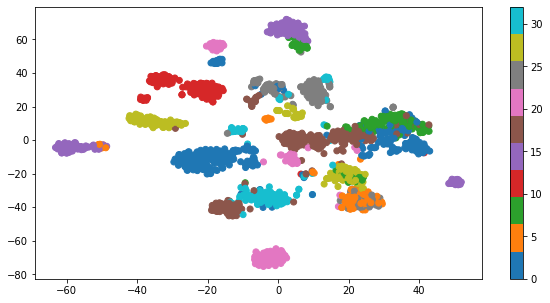

In [49]:
# run tSNE on testing codes
from sklearn.manifold import TSNE
test_codes_embedded = TSNE(n_components=2).fit_transform(X_test_cae)

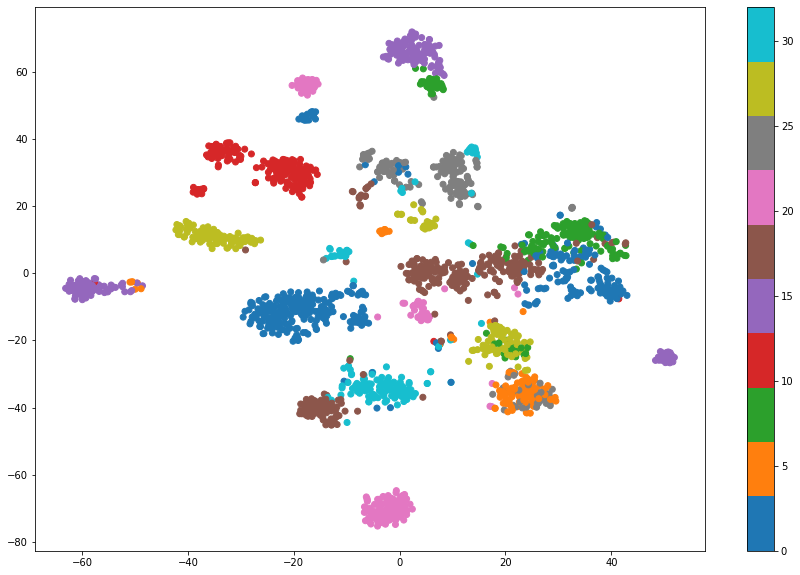

In [52]:
# plot tSNE results with MNIST labels
fig, ax = plt.subplots(figsize=(15, 10))
plt.scatter(test_codes_embedded[:,0], test_codes_embedded[:,1], c=np.argmax(y_test, axis=1), cmap=plt.get_cmap("tab10"))
plt.colorbar()

In [16]:
from scipy import sparse
import numpy as np
from sklearn.datasets import load_breast_cancer
import san
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import chi2,f_classif,mutual_info_classif
from sklearn.ensemble import RandomForestClassifier

# X_train_cae = np.reshape(encoded_imgs_train, (-1, 968))
# X_test_cae = np.reshape(encoded_imgs_test, (-1, 968))

X_train_cae =  X_train_cae.astype(int)
X_test_cae =  X_test_cae.astype(int)

Y_train_cae = np.argmax(y_train, axis=1)
Y_test_cae = np.argmax(y_test, axis=1)

In [21]:
san_cae = san.SAN(num_epochs = 32, num_heads = 2, batch_size = 128, dropout = 0.2, hidden_layer_size = 32)
#X_train = sparse.csr_matrix(X_train)
san_cae.fit(X_train_cae, Y_train_cae)

20-May-22 15:26:06 - Found 33 unique labels.
20-May-22 15:26:09 - Number of parameters 2846073
20-May-22 15:26:09 - Starting training for 32 epochs
20-May-22 15:26:12 - epoch 0, mean loss per batch 0.18960854697685975
20-May-22 15:26:13 - epoch 1, mean loss per batch 0.0675049062531728
20-May-22 15:26:15 - epoch 2, mean loss per batch 0.04764857274981645
20-May-22 15:26:16 - epoch 3, mean loss per batch 0.0375354677438736
20-May-22 15:26:18 - epoch 4, mean loss per batch 0.03336304775797404
20-May-22 15:26:19 - epoch 5, mean loss per batch 0.02956535526766227
20-May-22 15:26:21 - epoch 6, mean loss per batch 0.025980345016488663
20-May-22 15:26:22 - epoch 7, mean loss per batch 0.0239947337943774
20-May-22 15:26:24 - epoch 8, mean loss per batch 0.0221539536347756
20-May-22 15:26:25 - epoch 9, mean loss per batch 0.021082525356457785
20-May-22 15:26:27 - epoch 10, mean loss per batch 0.019627185696019577
20-May-22 15:26:29 - epoch 11, mean loss per batch 0.01854994805672994
20-May-22 1

In [41]:
elements = []
for index in range(0, 968):
    elements.append(features[index])

In [22]:
y_pred = san_cae.predict(X_test_cae)
global_attention_weights = san_cae.get_mean_attention_weights()
local_attention_matrix = san_cae.get_instance_attention(X_test_cae)
# mutual_information = mutual_info_classif(X_test_cae, Y_test_cae)
# rf = RandomForestClassifier().fit(X_test_cae, Y_test_cae).feature_importances_
# y_pred = rf.predict(X_test)
# y_pred = classifier.predict(x_test)
#y_pred = np.argmax(y_pred, axis=1)

print('MCC Score:: {}'.format(matthews_corrcoef(Y_test_cae, y_pred)))
print('Accuracy:: {}'.format(metrics.accuracy_score(Y_test_cae, y_pred)))
print('Precision:: {}'.format(metrics.precision_score(Y_test_cae, y_pred, average='weighted')))
print('Recall:: {}'.format(metrics.recall_score(Y_test_cae, y_pred, average='weighted')))
print('F_score:: {}'.format(metrics.f1_score(Y_test_cae, y_pred, average='weighted')))
print('classification_report:: {}'.format(classification_report(Y_test_cae, y_pred)))

Mcc Score:: 0.9321163275890934
Accuracy:: 0.9352030947775629
Precision:: 0.9362633451163748
Recall:: 0.9352030947775629
F_score:: 0.9345604029715034
classification_report::               precision    recall  f1-score   support

           0       1.00      0.94      0.97        16
           1       0.91      0.86      0.88        83
           2       0.99      0.98      0.99       222
           3       0.82      0.82      0.82        61
           4       1.00      0.71      0.83         7
           5       0.83      0.89      0.86        96
           6       1.00      1.00      1.00        10
           7       1.00      0.66      0.79        32
           8       1.00      1.00      1.00        33
           9       0.86      0.89      0.88       100
          10       0.81      1.00      0.90        13
          11       0.97      0.95      0.96       108
          12       0.95      0.91      0.93        58
          13       1.00      1.00      1.00        30
          14    

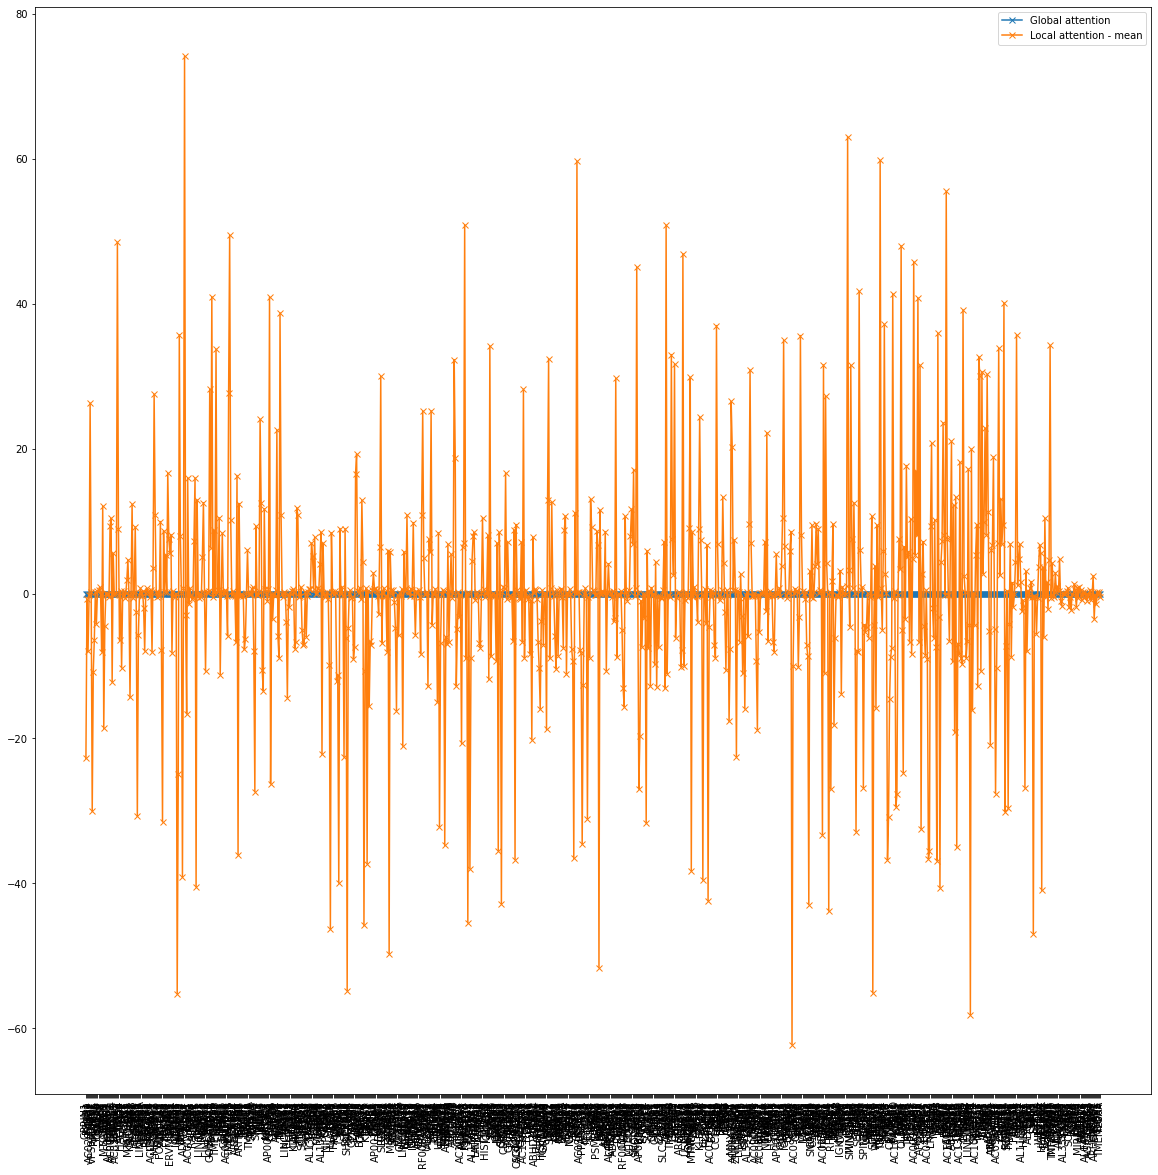

In [48]:
plt.figure(figsize=(20,20))
plt.plot(elements, global_attention_weights, label="Global attention", marker="x")
plt.plot(elements, np.mean(local_attention_matrix, axis=0), label="Local attention - mean", marker="x")
#plt.plot(np.max(elements, local_attention_matrix, axis=0), label="Local attention - max", marker="x")

plt.legend(loc=1)
plt.xticks(rotation=90)
#plt.tight_layout()
plt.show()